# Create feature matrix

## 1. Current task - short term

- psd and bins - used high pass filter, it's close to Andrew's, workable condition
- modifying aggregating functions to create feature matrix
- one hot encoding
- 

## 2. Task list

- ? fill NA for empty values
- DictVectorizer - LabelEncoder and OneHot
- Standardize or Normalize?
- Pipeline
- logreg
- svm
- PCA after 2 models?
- randomforest
- DL
- naivebayes

## 3. Import packages and paths

In [1]:
# Importing the Libraries
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr, iqr, zscore
from scipy.signal import butter, welch, filtfilt, resample
import time
import re
import copy
# import nolds
from sklearn import preprocessing
import scipy.io # test matlab code

from PreprocessFcns import *

%matplotlib inline

In [2]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
        folder_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data'
        dict_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
        features_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\FeatureMatrix'

## 4. Feature list

In [ ]:
colnames=['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
       'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
       'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
       'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
       'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
       'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

In [ ]:
features_list = ['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew',
                    'PSD_kur','jerk_mean','jerk_std','jerk_skew','jerk_kur','Sen_X','Sen_Y','Sen_Z']
len(features_list)

In [ ]:
# 37 features
len(colnames)
# acc and gyro = 74 features
# medial chest - acc
# 15 other sensors

## 5. Load HC02 dataset

In [240]:
# use context manager to load pickle file
dict_path2 = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
subj = 'HC02'
filename = os.path.join(dict_path2, subj + 'dict.pkl')
with open(filename,'rb') as filename:
    act_dict = pickle.load(filename)

In [241]:
act_dict

{'LYING': {0: {'tibialis_anterior_left': {'accel':                 Accel X (g)  Accel Y (g)  Accel Z (g)
    Timestamp (ms)                                       
    1510606218556     -0.046815    -0.898390     0.468818
    1510606218588     -0.051698    -0.899855     0.479561
    1510606218620     -0.054139    -0.908156     0.477607
    1510606218652     -0.050721    -0.893507     0.478584
    1510606218684     -0.058534    -0.900832     0.468330
    1510606218716     -0.050233    -0.904250     0.489326
    1510606218748     -0.045838    -0.912551     0.477119
    1510606218780     -0.048280    -0.902296     0.463935
    1510606218812     -0.045350    -0.900832     0.476143
    1510606218844     -0.055116    -0.906203     0.466865
    1510606218876     -0.047303    -0.898878     0.467842
    1510606218908     -0.038514    -0.901320     0.481514
    1510606218940     -0.049744    -0.902296     0.485420
    1510606218972     -0.052186    -0.903273     0.471748
    1510606219004     -0.

## 6. act_dict structure

In [203]:
act_dict.keys()

dict_keys(['LYING', 'SITTING', 'STANDING', 'WALKING', 'STAIRS DOWN', 'STAIRS UP'])

In [204]:
act_dict['LYING'].keys()

dict_keys([0, 1])

In [205]:
act_dict['LYING'][0].keys()

dict_keys(['tibialis_anterior_left', 'gastrocnemius_right', 'sacrum', 'distal_lateral_shank_right', 'tibialis_anterior_right', 'posterior_forearm_right', 'bicep_right', 'rectus_femoris_left', 'biceps_femoris_right', 'posterior_forearm_left', 'biceps_femoris_left', 'gastrocnemius_left', 'bicep_left', 'medial_chest', 'distal_lateral_shank_left', 'rectus_femoris_right'])

In [121]:
locations = ['tibialis_anterior_left', 'gastrocnemius_right', 'sacrum', 'distal_lateral_shank_right', 
             'tibialis_anterior_right', 'posterior_forearm_right', 'bicep_right', 'rectus_femoris_left', 
             'biceps_femoris_right', 'posterior_forearm_left', 'biceps_femoris_left', 'gastrocnemius_left', 
             'bicep_left', 'medial_chest', 'distal_lateral_shank_left', 'rectus_femoris_right']
for location in locations:
    print(act_dict['LYING'][0][location].keys())

dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])


# Test matlab vs python features

## Step 1: Create testclip

In [4]:
testclip = act_dict['WALKING'][0]['sacrum']['accel']
testclip.columns=['Accel_X', 'Accel_Y', 'Accel_Z']

In [12]:
testclip.head(3)

,Accel_X,Accel_Y,Accel_Z
Timestamp (ms),,,
1510606486688,0.010315,0.925002,0.245182
1510606486720,-0.009461,0.990311,0.212833
1510606486752,0.023865,1.028641,0.190494


In [13]:
# save testclip as csv
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclip.csv'
testclip.to_csv(testfile)

## Step 2: Create matclip from testclip to use Matlab feature extraction

In [9]:
matclip = testclip.reset_index(drop=True)

In [10]:
matclip.head(3)

,Accel_X,Accel_Y,Accel_Z
0,0.010315,0.925002,0.245182
1,-0.009461,0.990311,0.212833
2,0.023865,1.028641,0.190494


In [11]:
# transpose columns as rows
matclipT=matclip.T
matclipT

,0,1,2,3,4,5,6,7,8,9,...,409,410,411,412,413,414,415,416,417,418
Accel_X,0.010315,-0.009461,0.023865,0.015198,-0.083314,-0.169131,-0.067323,0.137514,0.048890,-0.126162,...,0.018006,-0.100160,-0.252262,0.009461,0.197574,-0.047669,-0.215030,-0.142397,-0.075257,-0.070008
Accel_Y,0.925002,0.990311,1.028641,0.983719,0.886671,0.942824,1.047440,1.080888,1.224323,1.232136,...,1.340047,1.286213,1.052201,0.887037,0.953201,1.105913,1.032181,0.820630,0.748730,0.831006
Accel_Z,0.245182,0.212833,0.190494,0.186587,0.190005,0.200137,0.211734,0.223331,0.244083,0.310002,...,0.236759,0.433295,0.499092,0.463569,0.442695,0.392279,0.297185,0.264958,0.264225,0.255680


In [12]:
# save as csv
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclipT.csv'
matclipT.to_csv(testfile)

In [13]:
# Savemat
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclipinmatlab'
# with open(testfile,'wb') as f:
scipy.io.savemat(testfile, matclip, oned_as='column')

Matlab code to combine test code and check features - getfeatures requires a 3xN array
[feature, label] = getfeatures(testclipT)
label = label' # transpose

#Creates 2x131 cell
matrix=vertcat(label,num2cell(feature)) # need to convert feature double array to cell array
#csvwrite('matlabfeatures.txt',matrix)

#Create 2x131 table with labels and features using Matlab code
x = array2table(matrix(2,:),'VariableNames',matrix(1,:))

#Take 2x131 cell called matrix
#write labels as header
fid = fopen('matlabfeatures.csv', 'w') ;
fprintf(fid, '%s,', x{1,1:end-1}) ;
fprintf(fid, '%s\n', x{1,end}) ;
fclose(fid) ;
#append numeric features then write to csv file
dlmwrite('matlabfeatures.csv', x(2:end,:), '-append') 

## Step 3: Load files to compare matlab vs python features
- load pythonfea in Step 5 first

In [11]:
# load csv file to check Matlab features
mfeatfile = r'C:\Users\lu-RT&O\Documents\GitHub/matlabfeatures.csv'
matlab = pd.read_csv(mfeatfile)

In [14]:
# change and reorder matlab columns
pythonfea = featuretest(testclip)

# colsm = matlab.columns.tolist() # check matlab column order
cols = pythonfea.columns.tolist()
# print(cols, '\n', colsm)

# change cross product column names since abs ones were duplicated
matlab.rename(index=str, columns={'abs CrossProd xy':'abs CrossProd norm xy',
                                  'abs CrossProd xz':'abs CrossProd norm xz',
                                  'abs CrossProd yz':'abs CrossProd norm yz',
                                  'abs CrossProd xy.1':'abs CrossProd xy',
                                  'abs CrossProd xz.1':'abs CrossProd xz',
                                  'abs CrossProd yz.1':'abs CrossProd yz'},
              inplace=True)

# reordered column list for matlab features
colsm = ['x-mean', 'y-mean', 'z-mean', 
         'x-range', 'y-range', 'z-range', 
         'x-IQR', 'y-IQR', 'z-IQR', 
         'x-std', 'y-std', 'z-std', 
         'x-skew', 'y-skew', 'z-skew', 
         'x-kurt', 'y-kurt', 'z-kurt', 
         'x-hist-2', 'x-hist-1', 'x-hist0', 'x-hist1',   
         'y-hist-2', 'y-hist-1', 'y-hist0', 'y-hist1', 
         'z-hist-2', 'z-hist-1', 'z-hist0', 'z-hist1', 
         'x-mean diff', 'y-mean diff', 'z-mean diff', 
         'x-std diff', 'y-std diff', 'z-std diff', 
         'x-skew diff', 'y-skew diff', 'z-skew diff', 
         'x-kurt diff', 'y-kurt diff', 'z-kurt diff', 
         'mean of squares', 
         'std_sum', 
         'corr coeff xy', 'corr coeff xz', 'corr coeff yz', 
         'CrossProd xy', 'CrossProd xz', 'CrossProd yz', 
         'CrossProd norm xy', 'CrossProd norm xz', 'CrossProd norm yz',
         'abs CrossProd xy', 'abs CrossProd xz', 'abs CrossProd yz', 
         'abs CrossProd norm xy', 'abs CrossProd norm xz', 'abs CrossProd norm yz', 
         'x-mean (PSD)', 'y-mean (PSD)', 'z-mean (PSD)', 
         'x-std (PSD)', 'y-std (PSD)', 'z-std (PSD)', 
         'x-skew (PSD)', 'y-skew (PSD)', 'z-skew (PSD)', 
         'x-kurt (PSD)', 'y-kurt (PSD)', 'z-kurt (PSD)', 
         'x_bin_5.000000e-01', 'x_bin_1', 'x_bin_1.500000e+00', 'x_bin_2', 
         'x_bin_2.500000e+00', 'x_bin_3', 'x_bin_3.500000e+00', 'x_bin_4', 
         'x_bin_4.500000e+00', 'x_bin_5', 'x_bin_5.500000e+00', 'x_bin_6', 
         'x_bin_6.500000e+00', 'x_bin_7', 'x_bin_7.500000e+00', 'x_bin_8', 
         'x_bin_8.500000e+00', 'x_bin_9', 'x_bin_9.500000e+00', 'x_bin_10', 
         'y_bin_5.000000e-01', 'y_bin_1', 'y_bin_1.500000e+00', 'y_bin_2', 
         'y_bin_2.500000e+00', 'y_bin_3', 'y_bin_3.500000e+00', 'y_bin_4', 
         'y_bin_4.500000e+00', 'y_bin_5', 'y_bin_5.500000e+00', 'y_bin_6', 
         'y_bin_6.500000e+00', 'y_bin_7', 'y_bin_7.500000e+00', 'y_bin_8', 
         'y_bin_8.500000e+00', 'y_bin_9', 'y_bin_9.500000e+00', 'y_bin_10', 
         'z_bin_5.000000e-01', 'z_bin_1', 'z_bin_1.500000e+00', 'z_bin_2', 
         'z_bin_2.500000e+00', 'z_bin_3', 'z_bin_3.500000e+00', 'z_bin_4', 
         'z_bin_4.500000e+00', 'z_bin_5', 'z_bin_5.500000e+00', 'z_bin_6', 
         'z_bin_6.500000e+00', 'z_bin_7', 'z_bin_7.500000e+00', 'z_bin_8', 
         'z_bin_8.500000e+00', 'z_bin_9', 'z_bin_9.500000e+00', 'z_bin_10']

# reorder matlab feature columns
matlab = matlab[colsm]

In [15]:
# check contents
matlab

,x-mean,y-mean,z-mean,x-range,y-range,z-range,x-IQR,y-IQR,z-IQR,x-std,...,z_bin_5.500000e+00,z_bin_6,z_bin_6.500000e+00,z_bin_7,z_bin_7.500000e+00,z_bin_8,z_bin_8.500000e+00,z_bin_9,z_bin_9.500000e+00,z_bin_10
0,-0.028107,0.98163,0.28277,0.71717,0.94179,0.74696,0.15531,0.27298,0.21491,0.11811,...,0.000886,0.002759,0.000117,0.000169,0.000288,0.000677,0.000164,0.000195,0.000103,0.000026


## Step 4: Load testclip for python features

In [7]:
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclip.csv'
testclip = pd.read_csv(testfile)
testclip = testclip.drop('Timestamp (ms)', 1)

In [9]:
testclip.shape

(419, 3)

In [10]:
testclip.head(3)

,Accel_X,Accel_Y,Accel_Z
0,0.010315,0.925002,0.245182
1,-0.009461,0.990311,0.212833
2,0.023865,1.028641,0.190494


## Step 5: Test features - matlab vs python using testclip

### 1. View feature sets side by side

#### Reload featuretest() starting here

In [120]:
# with timestep
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclip.csv'
testclip = pd.read_csv(testfile, index_col=0)
# without timestamp
# testclip = pd.read_csv(testfile)
# testclip = testclip.drop('Timestamp (ms)', 1)

In [121]:
testclip.head(3)

,Accel_X,Accel_Y,Accel_Z
Timestamp (ms),,,
1510606486688,0.010315,0.925002,0.245182
1510606486720,-0.009461,0.990311,0.212833
1510606486752,0.023865,1.028641,0.190494


In [146]:
# extract features with featuretest and compared to matlab features
pythonfea = featuretest(testclip)
# cleanup type
pythonfea2 = pythonfea.astype('float64')
pythonfea2 = pythonfea2.apply(np.format_float_positional, precision=6)
pythonfea2 = pythonfea2.to_frame()

In [147]:
# view 2 dataframes side by side: Matlab vs Python
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
display_side_by_side(matlab.T,pythonfea2)

,0
x-mean,-0.028107
y-mean,0.981630
z-mean,0.282770
x-range,0.717170
y-range,0.941790
z-range,0.746960
x-IQR,0.155310
y-IQR,0.272980
z-IQR,0.214910
x-std,0.118110


### 2. Calculate error in feature sets

In [148]:
# calculate % error for python vs matlab features

# transpose matlab to match pythonfea2
matlabT = matlab.T
# create same index of feature names
matlabT.index = pythonfea2.index
# combine python and matlab features in 1 dataframe
result = pd.concat([pythonfea2, matlabT], axis=1, sort=False)
# rename columns - python matlab percenterror
result.columns = ['python','matlab']
# change from str to float type
result.python = result.python.astype('float64')
# add percent error column
result['percenterror'] = (result['python'] - result['matlab'])*100/result['matlab']
# add absolute error column
result['abs_error'] = abs(result['python'] - result['matlab'])
# cleanup index
result.reset_index(inplace=True)
result = result.rename(columns={'index':'feature'})

In [497]:
result[30:50]

,feature,python,matlab,percenterror,abs_error
30,mean_derivative_x,-0.000192,-0.000192,-8.326395e-02,1.600000e-07
31,mean_derivative_y,-0.000225,-0.000225,5.781118e-02,1.300000e-07
32,mean_derivative_z,0.000025,0.000025,-4.578937e-01,1.150000e-07
33,std_derivative_x,0.131300,0.131460,-1.217100e-01,1.600000e-04
34,std_derivative_y,0.189824,0.190050,-1.189161e-01,2.260000e-04
35,std_derivative_z,0.097145,0.097261,-1.192667e-01,1.160000e-04
36,skew_derivative_x,-0.188444,-0.188440,2.122692e-03,4.000000e-06
37,skew_derivative_y,-0.223380,-0.223380,-1.242527e-14,2.775558e-17
38,skew_derivative_z,1.192307,1.192300,5.871006e-04,7.000000e-06
39,kurt_derivative_x,4.614380,4.614400,-4.334258e-04,2.000000e-05


### 3. Test individual features

#### 3.1 Test sum_stddev feature

In [47]:
result.loc[result.feature == 'sum_stddev']

,feature,python,matlab,percenterror,abs_error
43,sum_stddev,0.46835,0.46835,0.0,0.0


In [48]:
print(result.loc[result.feature == 'stddev_X'])
print(result.loc[result.feature == 'stddev_Y'])
print(result.loc[result.feature == 'stddev_Z'])

    feature    python   matlab  percenterror  abs_error
9  stddev_X  0.118108  0.11811     -0.001693   0.000002
     feature    python   matlab  percenterror  abs_error
10  stddev_Y  0.201473  0.20147      0.001489   0.000003
     feature    python   matlab  percenterror  abs_error
11  stddev_Z  0.148769  0.14877     -0.000672   0.000001


In [49]:
result.loc[9]+result.loc[10]+result.loc[11]

feature         stddev_Xstddev_Ystddev_Z
python                           0.46835
matlab                           0.46835
percenterror                 -0.00087646
abs_error                          6e-06
dtype: object

#### 3.2 Test derivative or difference

In [84]:
result[30:42]

,feature,python,matlab,percenterror,abs_error
30,mean_derivative_x,-0.000192,-0.000192,-8.326395e-02,1.600000e-07
31,mean_derivative_y,-0.000225,-0.000225,5.781118e-02,1.300000e-07
32,mean_derivative_z,0.000025,0.000025,-4.578937e-01,1.150000e-07
33,std_derivative_x,0.131300,0.131460,-1.217100e-01,1.600000e-04
34,std_derivative_y,0.189824,0.190050,-1.189161e-01,2.260000e-04
35,std_derivative_z,0.097145,0.097261,-1.192667e-01,1.160000e-04
36,skew_derivative_x,-0.188444,-0.188440,2.122692e-03,4.000000e-06
37,skew_derivative_y,-0.223380,-0.223380,-1.242527e-14,2.775558e-17
38,skew_derivative_z,1.192307,1.192300,5.871006e-04,7.000000e-06
39,kurt_derivative_x,4.614380,4.614400,-4.334258e-04,2.000000e-05


#### 3.4 Test mean squared norm (or mean of squares in matlab)

In [85]:
result[42:43]

,feature,python,matlab,percenterror,abs_error
42,mean_squared_norm,0.373615,0.37361,0.001338,0.000005


#### 3.5 Test correlation coefficients
- Used np.corrcoef instead of np.correlate

In [87]:
# before changes
result[44:47]

,feature,python,matlab,percenterror,abs_error
44,xcorr_XY,-11.497544,0.006345,-181297.799946,11.503889
45,xcorr_XZ,-4.190390,0.036849,-11471.787565,4.227239
46,xcorr_YZ,116.768120,-0.117110,-99808.069337,116.885230


In [111]:
# xcorr_XY
np.corrcoef(testclip.iloc[:,0],testclip.iloc[:,1])[0][1]

0.006345321541608315

In [134]:
# xcorr_XZ
np.corrcoef(testclip.iloc[:,0],testclip.iloc[:,2])[0][1]

-0.11711381488734753

In [114]:
# xcorr_YZ
np.corrcoef(testclip.iloc[:,1],testclip.iloc[:,2])[0][1]

0.03684870063379716

In [148]:
# after changes
result[44:47]

,feature,python,matlab,percenterror,abs_error
44,xcorr_XY,0.006345,0.006345,-0.004728,3.000000e-07
45,xcorr_XZ,-0.117114,-0.117110,0.003416,4.000000e-06
46,xcorr_YZ,0.036849,0.036849,0.000000,0.000000e+00


#### 3.6 Test norm, cross products of norm

In [324]:
tempnorm = np.ones((len(testclip.columns),1))*np.array(np.sqrt(np.sum(np.square(testclip),axis=1)))

In [343]:
finalnorm = testclip/tempnorm.T

In [344]:
finalnorm.head(3)

,Accel_X,Accel_Y,Accel_Z
0,0.010779,0.966564,0.256198
1,-0.009339,0.977633,0.210108
2,0.022807,0.983025,0.182046


In [345]:
# crossprod_norm_xy, should be -0.024382
np.nanmean(finalnormT.iloc[:,0]*finalnormT.iloc[:,1])

-0.024382217543411144

In [356]:
# check changes
print(result[50:53], result[56:59])

              feature    python    matlab  percenterror     abs_error
50  crossprod_norm_xy -0.024382 -0.024382     -0.000000  0.000000e+00
51  crossprod_norm_xz -0.008711 -0.008711     -0.004592  4.000000e-07
52  crossprod_norm_yz  0.251377  0.251380     -0.001193  3.000000e-06                   feature    python    matlab  percenterror     abs_error
56  abs_crossprod_norm_xy  0.024382  0.024382      0.000000  0.000000e+00
57  abs_crossprod_norm_xz  0.008711  0.008711     -0.004592  4.000000e-07
58  abs_crossprod_norm_yz  0.251377  0.251380     -0.001193  3.000000e-06


#### 3.7 Histogram of z-scores

In [401]:
testclip-np.mean(testclip)/np.std(testclip.iloc[:,0], ddof=1)
histtest = testclip-np.mean(testclip)/np.std(testclip,ddof=1)
np.histogram(histtest.iloc[:,0],bins=4, range=(-2,2))

(array([  0,  19, 400,   0], dtype=int64), array([-2., -1.,  0.,  1.,  2.]))

In [409]:
result[18:30]

,feature,python,matlab,percenterror,abs_error
18,hist1_X,0.0,0.0,NaN,0.0
19,hist2_X,19.0,19.0,0.0,0.0
20,hist3_X,400.0,400.0,0.0,0.0
21,hist4_X,0.0,0.0,NaN,0.0
22,hist1_Y,0.0,0.0,NaN,0.0
23,hist2_Y,0.0,0.0,NaN,0.0
24,hist3_Y,0.0,0.0,NaN,0.0
25,hist4_Y,0.0,0.0,NaN,0.0
26,hist1_Z,419.0,419.0,0.0,0.0
27,hist2_Z,0.0,0.0,NaN,0.0


#### 3.8 Test PSD
- frequency matches
- amplitude similar
- adjusted original parameters to fit Matlab features

- Note: Matlab code uses High Pass filter first, then Welch for PSD and binning

In [ ]:
# matlab code
%% Frequency Domain Processing (High Pass + Power Spectra)
filtered = cell(3,1);
PSD_welch = cell(3,1);
f_welch = cell(3,1);
fc = 0.2; %cutoff frequency (Hz)
fs = 30;
f_nyq = fs/2;

%High Pass Filter
for ii = 1:3
    [b, a] = butter(2,(fc*pi)/f_nyq,'high');
    filtered{ii} = filter(b,a,S(ii,:)); 
end

%Power Spectra
for ii = 1:3
    win_size = ceil(length(filtered{ii})/2);
    [PSD_welch{ii}, f_welch{ii}] = pwelch(filtered{ii}, win_size, [], [], fs);
end

%% Features for Each Axis (Frequency Domain)
for ii = 1:3

    %Mean 
    fvec = [fvec nanmean(PSD_welch{ii})]; flab = [flab; [axes{ii} '-mean (PSD)']];

In [233]:
# check PSD features
result[59:71]

,feature,python,matlab,percenterror,abs_error
59,PSD_mean_X,0.001309,0.001023,27.919476,0.000286
60,PSD_mean_Y,0.004213,0.002769,52.148790,0.001444
61,PSD_mean_Z,0.004213,0.001678,151.012869,0.002535
62,PSD_std_X,0.002657,0.002488,6.814070,0.000169
63,PSD_std_Y,0.012979,0.009817,32.216167,0.003162
64,PSD_std_Z,0.012979,0.008670,49.694936,0.004309
65,PSD_skew_X,4.201396,4.822400,-12.877488,0.621004
66,PSD_skew_Y,4.741735,5.532100,-14.286889,0.790365
67,PSD_skew_Z,4.741735,8.018800,-40.867274,3.277065
68,PSD_kur_X,20.541471,30.106000,-31.769511,9.564529


##### check butter() param: N in HPfilter

In [172]:
butter(2,0.75/(0.5*32),btype='highpass',analog=False)

(array([ 0.90109585, -1.80219171,  0.90109585]),
 array([ 1.        , -1.79238564,  0.81199778]))

In [160]:
#Matlab butter in HP filter
# fs = 30, but I used 32 (use 30 for comparison?)
butter(2,(0.2*math.pi)/(30/2),btype='highpass',analog=False)

(array([ 0.9111386 , -1.82227721,  0.9111386 ]),
 array([ 1.        , -1.81436521,  0.83018921]))

Matlab output for x axis
params: array, win_size = 210, noverlap, f=some vector, fs=sample rate
[PSD_welch, f_welch] = pwelch(s(1,:), 210, [], [], 30)

f_welch =
         0
    0.1172
    0.2344
    0.3516
    0.4688

PSD_welch =
    0.0020
    0.0008
    0.0002
    0.0001
    0.0001

Python equivalent
- f_welch 0.       ,  0.1171875,  0.234375 ,  0.3515625,  0.46875  ,
- PSD 3.25891926e-06, 6.70944383e-04, 4.60312756e-04, 5.17537671e-05,
        3.41573502e-05, 1.52932578e-04, 2.64206412e-04, 1.66773013e-03,
        8.03962435e-03, 1.96434924e-03, 7.59507165e-05, 3.73367614
Number of points to overlap between segmene-05,
        2.62080686e-04, 2.14793365e-04, 1.47234345e-04, 5.42776542e-04,
        1.78089195e-03, 1.77307600e-03, 4.21337862e-04, 7.62464287e-05,
        1.84090034e-04, 9.25590985e-05, 6.66485661e-04, 1.03408781e-03,
        
        1.25603781e-06, 3.62593255e-05, 2.40640066e-04, 9.56517874e-05,
        1.55290534e-05, 5.33191601e-05, 4.12289961e-04, 1.28142207e-03,
        9.70177433e-03, 2.88202699e-03, 5.21970648e-05, 3.95020222e-05,

In [212]:
welch(rawclip.iloc[:,0],fs=32,nperseg=min(256,len(rawclip.iloc[:,0])),detrend=False)

(array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
         1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
         2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
         3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
         4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
         5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
         6.   ,  6.125,  6.25 ,  6.375,  6.5  ,  6.625,  6.75 ,  6.875,
         7.   ,  7.125,  7.25 ,  7.375,  7.5  ,  7.625,  7.75 ,  7.875,
         8.   ,  8.125,  8.25 ,  8.375,  8.5  ,  8.625,  8.75 ,  8.875,
         9.   ,  9.125,  9.25 ,  9.375,  9.5  ,  9.625,  9.75 ,  9.875,
        10.   , 10.125, 10.25 , 10.375, 10.5  , 10.625, 10.75 , 10.875,
        11.   , 11.125, 11.25 , 11.375, 11.5  , 11.625, 11.75 , 11.875,
        12.   , 12.125, 12.25 , 12.375, 12.5  , 12.625, 12.75 , 12.875,
        13.   , 13.125, 13.25 , 13.375, 13.5  , 13.625, 13.75 , 

In [184]:
# clip with timestamp index
rawclip = act_dict['WALKING'][0]['sacrum']['accel']

In [417]:
testfs = np.mean(1/(np.diff(rawclip.iloc[:,0].index)/1000))
print(testfs)

31.238672611280265


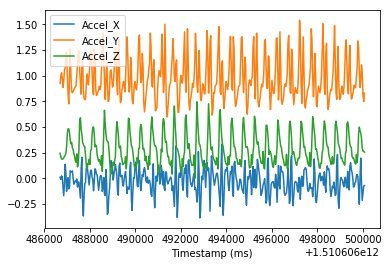

In [185]:
# plot raw data
rawclip.plot()

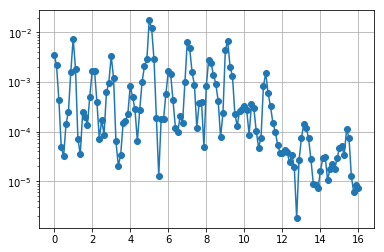

In [211]:
# plot scipy welch - x axis
f, p = welch(rawclip.iloc[:,0],fs=32,nperseg=min(256,len(rawclip.iloc[:,0])),detrend=False)
plt.semilogy(f, p, '-o')
plt.grid()
plt.show()
# added detrend=False, 

Plot PSD on each axis separately to compare to Matlab plots.

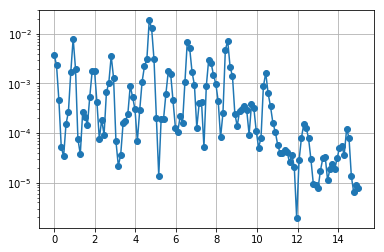

In [477]:
# plot scipy welch - x axis
f, p = welch(rawclip.iloc[:,0],fs=30,nperseg=256,detrend=False)
plt.semilogy(f, p, '-o')
plt.grid()
plt.show()
# added detrend=False, 

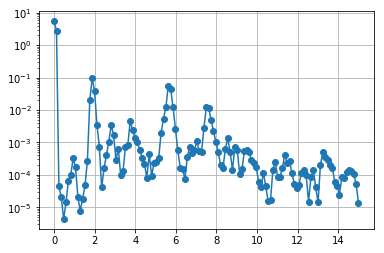

In [488]:
# plot scipy welch - y axis
f, p = welch(rawclip.iloc[:,1],fs=30,nperseg=256,detrend=False)
plt.semilogy(f, p, '-o')
plt.grid()
plt.show()

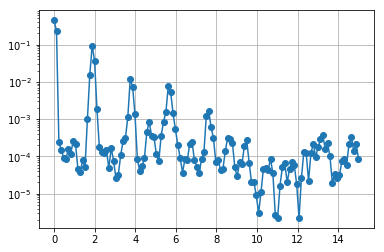

In [489]:
# plot scipy welch - z axis
f, p = welch(rawclip.iloc[:,2],fs=30,nperseg=256,detrend=False)
plt.semilogy(f, p, '-o')
plt.grid()
plt.show()

In [ ]:
# +3 to kurtosis ???

#### 3.9 Test PSD bins
- rerun next 3 code chunks to check PSD binning features

In [225]:
# extract features with featuretest and compared to matlab features
pythonfea = featuretest(testclip)
# cleanup type
pythonfea2 = pythonfea.astype('float64')
pythonfea2 = pythonfea2.apply(np.format_float_positional, precision=6)
pythonfea2 = pythonfea2.to_frame()

In [226]:
# view 2 dataframes side by side: Matlab vs Python
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
display_side_by_side(matlab.T,pythonfea2)

,0
x-mean,-0.028107
y-mean,0.981630
z-mean,0.282770
x-range,0.717170
y-range,0.941790
z-range,0.746960
x-IQR,0.155310
y-IQR,0.272980
z-IQR,0.214910
x-std,0.118110


In [227]:
# calculate % error for python vs matlab features

# transpose matlab to match pythonfea2
matlabT = matlab.T
# create same index of feature names
matlabT.index = pythonfea2.index
# combine python and matlab features in 1 dataframe
result = pd.concat([pythonfea2, matlabT], axis=1, sort=False)
# rename columns - python matlab percenterror
result.columns = ['python','matlab']
# change from str to float type
result.python = result.python.astype('float64')
# add percent error column
result['percenterror'] = (result['python'] - result['matlab'])*100/result['matlab']
# add absolute error column
result['abs_error'] = abs(result['python'] - result['matlab'])
# cleanup index
result.reset_index(inplace=True)
result = result.rename(columns={'index':'feature'})

In [153]:
# test HighPass then binning
result[71:].head(10)

,feature,python,matlab,percenterror,abs_error
71,meanpower_bin1_x,0.000000,0.000022,-100.000000,0.000022
72,meanpower_bin2_x,0.001980,0.002476,-20.038769,0.000496
73,meanpower_bin3_x,0.000486,0.000754,-35.546331,0.000268
74,meanpower_bin4_x,0.000891,0.000955,-6.732823,0.000064
75,meanpower_bin5_x,0.000194,0.000412,-52.946883,0.000218
76,meanpower_bin6_x,0.001641,0.001164,41.015726,0.000477
77,meanpower_bin7_x,0.000071,0.000138,-48.528346,0.000067
78,meanpower_bin8_x,0.000430,0.000378,13.801773,0.000052
79,meanpower_bin9_x,0.000922,0.002287,-59.678125,0.001365
80,meanpower_bin10_x,0.009473,0.008926,6.130543,0.000547


In [167]:
# HP + binning
# adjust power_spectra_welch_axis welch() butter param N=2 (vs 4)
result[71:].head(10)

,feature,python,matlab,percenterror,abs_error
71,meanpower_bin1_x,0.000001,0.000022,-95.366938,0.000021
72,meanpower_bin2_x,0.001375,0.002476,-44.471367,0.001101
73,meanpower_bin3_x,0.000351,0.000754,-53.450128,0.000403
74,meanpower_bin4_x,0.000855,0.000955,-10.501193,0.000100
75,meanpower_bin5_x,0.000189,0.000412,-54.159593,0.000223
76,meanpower_bin6_x,0.001628,0.001164,39.898599,0.000464
77,meanpower_bin7_x,0.000071,0.000138,-48.528346,0.000067
78,meanpower_bin8_x,0.000429,0.000378,13.537118,0.000051
79,meanpower_bin9_x,0.000921,0.002287,-59.721858,0.001366
80,meanpower_bin10_x,0.009466,0.008926,6.052119,0.000540


In [228]:
# HP + binning
# adjust power_spectra_welch_axis welch() butter param N=2 (vs 4)
# adjust power_spectra_welch_axis welch nperseg to min
# adjust power_spectra_welch_axis welch, + detrend=False
# kept welch param fs=32 (Matlab used fs=30)
result[71:].head(10)

,feature,python,matlab,percenterror,abs_error
71,meanpower_bin1_x,0.000001,0.000022,-95.366938,0.000021
72,meanpower_bin2_x,0.001320,0.002476,-46.692513,0.001156
73,meanpower_bin3_x,0.000338,0.000754,-55.174197,0.000416
74,meanpower_bin4_x,0.000615,0.000955,-35.623665,0.000340
75,meanpower_bin5_x,0.000571,0.000412,38.491390,0.000159
76,meanpower_bin6_x,0.001277,0.001164,9.736186,0.000113
77,meanpower_bin7_x,0.000338,0.000138,145.034073,0.000200
78,meanpower_bin8_x,0.000351,0.000378,-7.105994,0.000027
79,meanpower_bin9_x,0.000287,0.002287,-87.448614,0.002000
80,meanpower_bin10_x,0.006042,0.008926,-32.308589,0.002884


### 4. Save result dataframe with testclip

In [ ]:
# check result of python vs matlab features
result

In [231]:
# save as csv
testfile = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data analysis\Analysis_ActivityRecognition\matlabpython_features.csv'
result.to_csv(testfile)

# Functions to test simple clip - no trial, sensor dict keys
- compare feature results with python vs matlab features

Functions:
- power_spectra_welch_axis(rawdata,fm,fM)
- 

In [234]:
def power_spectra_welch_axis(rawdata,fm,fM):
    """Compute PSD on each axis then combine into a dataframe"""
    x = rawdata.iloc[:,0]
    y = rawdata.iloc[:,1]
    z = rawdata.iloc[:,2]
    # number of samples in clip
    n = len(x)
    # sampling rate in clip
    Fs = np.mean(1/(np.diff(x.index)/1000))
    
    # adjusted params to match frequency using scipy.welch with matlab.pwelch
#     fx,Pxx_denX = welch(x,fs=30,nperseg=256,detrend=False)
#     fy,Pxx_denY = welch(y,fs=30,nperseg=256,detrend=False)
#     fz,Pxx_denZ = welch(z,fs=30,nperseg=256,detrend=False)
    # added param: detrend=False
    fx,Pxx_denX = welch(x,Fs,nperseg=min(256,n),detrend=False)
    fy,Pxx_denY = welch(y,Fs,nperseg=min(256,n),detrend=False)
    fz,Pxx_denZ = welch(z,Fs,nperseg=min(256,n),detrend=False)
    
    #return PSD in desired interval of freq
    inds = (fx<=fM)&(fx>=fm)
    f=fx[inds]
    Pxx_denX=Pxx_denX[inds]
    Pxx_denY=Pxx_denY[inds]
    Pxx_denZ=Pxx_denZ[inds]
    Pxx_den = {'PSD_X':Pxx_denX,'PSD_Y':Pxx_denY,'PSD_Z':Pxx_denY}
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f)

    return Pxxdf

In [235]:
def featuretest(clip_data):
    """
    Extract features from a simple clip of a single trial and sensor
    Input: simple clip without trial or sensor dict keys
    Output: feature matrix from all clips from given subject and scores for each clip
    Column names separate for acc and gyro data.
    """
    
    features_list = ['meanX','meanY','meanZ','rangeX','rangeY','rangeZ','iqrX','iqrY','iqrZ',
                     'stddev_X','stddev_Y','stddev_Z','skewX','skewY','skewZ','kurtX','kurtY','kurtZ',
                     'hist1_X','hist2_X','hist3_X','hist4_X',
                     'hist1_Y','hist2_Y','hist3_Y','hist4_Y',
                     'hist1_Z','hist2_Z','hist3_Z','hist4_Z',
                     #Moments of derivative: mean, SD, skew, kurtosis
                     'mean_derivative_x','mean_derivative_y','mean_derivative_z',
                     'std_derivative_x','std_derivative_y','std_derivative_z',
                     'skew_derivative_x','skew_derivative_y','skew_derivative_z',
                     'kurt_derivative_x','kurt_derivative_y','kurt_derivative_z',
                     'mean_squared_norm','sum_stddev',
                     'xcorr_XY','xcorr_XZ','xcorr_YZ',
                     'crossprod_raw_xy','crossprod_raw_xz','crossprod_raw_yz',
                     'crossprod_norm_xy','crossprod_norm_xz','crossprod_norm_yz',
                     'abs_crossprod_raw_xy','abs_crossprod_raw_xz','abs_crossprod_raw_yz',
                     'abs_crossprod_norm_xy','abs_crossprod_norm_xz','abs_crossprod_norm_yz',
                     'PSD_mean_X','PSD_mean_Y','PSD_mean_Z',
                     'PSD_std_X','PSD_std_Y','PSD_std_Z',
                     'PSD_skew_X','PSD_skew_Y','PSD_skew_Z',
                     'PSD_kur_X','PSD_kur_Y','PSD_kur_Z',
                     # mean power 20 bins
                     # x axis
                     'meanpower_bin1_x','meanpower_bin2_x','meanpower_bin3_x','meanpower_bin4_x',
                     'meanpower_bin5_x','meanpower_bin6_x','meanpower_bin7_x','meanpower_bin8_x',
                     'meanpower_bin9_x','meanpower_bin10_x','meanpower_bin11_x','meanpower_bin12_x',
                     'meanpower_bin13_x','meanpower_bin14_x','meanpower_bin15_x','meanpower_bin16_x',
                     'meanpower_bin17_x','meanpower_bin18_x','meanpower_bin19_x','meanpower_bin20_x',
                     # y axis
                     'meanpower_bin1_y','meanpower_bin2_y','meanpower_bin3_y','meanpower_bin4_y',
                     'meanpower_bin5_y','meanpower_bin6_y','meanpower_bin7_y','meanpower_bin8_y',
                     'meanpower_bin9_y','meanpower_bin10_y','meanpower_bin11_y','meanpower_bin12_y',
                     'meanpower_bin13_y','meanpower_bin14_y','meanpower_bin15_y','meanpower_bin16_y',
                     'meanpower_bin17_y','meanpower_bin18_y','meanpower_bin19_y','meanpower_bin20_y',
                     # z axis
                     'meanpower_bin1_z','meanpower_bin2_z','meanpower_bin3_z','meanpower_bin4_z',
                     'meanpower_bin5_z','meanpower_bin6_z','meanpower_bin7_z','meanpower_bin8_z',
                     'meanpower_bin9_z','meanpower_bin10_z','meanpower_bin11_z','meanpower_bin12_z',
                     'meanpower_bin13_z','meanpower_bin14_z','meanpower_bin15_z','meanpower_bin16_z',
                     'meanpower_bin17_z','meanpower_bin18_z','meanpower_bin19_z','meanpower_bin20_z',]


    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    rawdata = clip_data

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis - mean, std dev, skew, kurtosis
    mean = np.asarray(np.mean(rawdata,axis=0))
    # np.std default ddof=0 as default so changed to 1 to match matlab
    std = np.asarray(np.std(rawdata,axis=0, ddof=1))
    sk = skew(rawdata)
    # kurtosis has difference of +3 with matlab feature, thus the offset
    kurt = kurtosis(rawdata)+3

    #Cross-correlation between axes pairs
    xcorr_xy = np.corrcoef(rawdata.iloc[:,0],rawdata.iloc[:,1])[0][1]
    xcorr_xz = np.corrcoef(rawdata.iloc[:,0],rawdata.iloc[:,2])[0][1]
    xcorr_yz = np.corrcoef(rawdata.iloc[:,1],rawdata.iloc[:,2])[0][1]
    xcorr = np.array([xcorr_xy, xcorr_xz, xcorr_yz])

    # interquartile range
    iqrange = iqr(rawdata,axis=0)
    
    # histogram of z-score values
    hist = rawdata-np.mean(rawdata)/np.std(rawdata,ddof=1)
    hist_z_scores_x = np.histogram(hist.iloc[:,0],bins=4, range=(-2,2))
    hist_z_scores_y = np.histogram(hist.iloc[:,1], bins=4, range=(-2,2))
    hist_z_scores_z = np.histogram(hist.iloc[:,2], bins=4, range=(-2,2))
    
    hist_z_scores = np.concatenate((hist_z_scores_x[0], hist_z_scores_y[0], hist_z_scores_z[0]), axis=None)

    # derivative - for 3 axis
    derivative = np.diff(rawdata, axis=0)
    # mean of derivative
    mean_derivative = np.mean(derivative,axis=0)
    # std dev of derivative
    std_derivative = np.std(derivative,axis=0)
    # skewness of derivative
    skew_derivative = skew(derivative,axis=0)
    # kurtosis of derivative
        # added offset +3
    kurt_derivative = kurtosis(derivative,axis=0)+3
    moments_of_derivative = np.concatenate((mean_derivative,std_derivative,skew_derivative,kurt_derivative), axis=None)

    # sum of xyz std dev
    sum_stddev = np.array([np.sum(std)])

    # mean of the squared norm
    mean_squared_norm = np.array([np.mean(np.mean(np.square(rawdata)))])

    # normalize values (divided by acc norm) to get cross products
    # The norm should sum across xyz axis at each instance of time
    normdenominator = np.ones((len(rawdata.columns),1))*np.array(np.sqrt(np.sum(np.square(rawdata),axis=1)))
    norm = rawdata/normdenominator.T
    
    # cross products with raw and norm data
    crossprod_norm_xy = np.nanmean(norm.iloc[:,0]*norm.iloc[:,1])
    crossprod_norm_xz = np.nanmean(norm.iloc[:,0]*norm.iloc[:,2])
    crossprod_norm_yz = np.nanmean(norm.iloc[:,1]*norm.iloc[:,2])
    abs_crossprod_norm_xy = np.abs(crossprod_norm_xy)
    abs_crossprod_norm_xz = np.abs(crossprod_norm_xz)
    abs_crossprod_norm_yz = np.abs(crossprod_norm_yz)
    crossprod_raw_xy = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,1])
    crossprod_raw_xz = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,2])
    crossprod_raw_yz = np.nanmean(rawdata.iloc[:,1]*rawdata.iloc[:,2])
    abs_crossprod_raw_xy = np.abs(crossprod_raw_xy)
    abs_crossprod_raw_xz = np.abs(crossprod_raw_xz)
    abs_crossprod_raw_yz = np.abs(crossprod_raw_yz)
    crossprod = np.array([crossprod_raw_xy, crossprod_raw_xz, crossprod_raw_yz,
                          crossprod_norm_xy, crossprod_norm_xz, crossprod_norm_yz,
                          abs_crossprod_raw_xy, abs_crossprod_raw_xz, abs_crossprod_raw_yz,
                          abs_crossprod_norm_xy, abs_crossprod_norm_xz, abs_crossprod_norm_yz])
    
    # High pass filter before passing to PSD (to compare with Matlab process)
    rawdata = HPfilter_testclip(rawdata)
    
    # power spectral density (PSD)
# changed fm=0, to fm=1 like Andrew's code
    Pxx = power_spectra_welch_axis(rawdata,fm=0,fM=10)
    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx.iloc[:,0].values),np.nanmean(Pxx.iloc[:,1].values),np.nanmean(Pxx.iloc[:,2].values),
            np.nanstd(Pxx.iloc[:,0].values),np.nanstd(Pxx.iloc[:,1].values),np.nanstd(Pxx.iloc[:,2].values),
            skew(Pxx.iloc[:,0].values),skew(Pxx.iloc[:,1].values),skew(Pxx.iloc[:,2].values),
            kurtosis(Pxx.iloc[:,0].values),kurtosis(Pxx.iloc[:,1].values),kurtosis(Pxx.iloc[:,2].values)])
########################
    # Mean power in 0.5 Hz bins between 0 and 10 Hz (x, y, z)
    binedges = np.arange(0,10.5,0.5)
    powerbin_df = Pxx.groupby(pd.cut(Pxx.index, bins=binedges)).mean().fillna(0)
    powerbinarray = np.concatenate((powerbin_df.iloc[:,0],powerbin_df.iloc[:,1],powerbin_df.iloc[:,2]), axis=None)

#     # Andrew's mean PSD binning code
#     #power spectra averaged within bins
#     fm = 1; fM = 10; nbins = 10 #frequency bins
# # figure x=Pxx ?
#     Fs = np.mean(1/(np.diff(Pxx.index)/1000)) # sampling rate in clip
#     n = Pxx.size
#     timestep = 1/Fs
#     bin1 = int(timestep*n*fm)
#     bin2 = int(timestep*n*fM)
#     bins = np.linspace(bin1,bin2,nbins,dtype=int) #sample indices
#     deltab = int(0.5*np.diff(bins)[0]) #half the size of bin (in samples)
#     Pxxm = []
#     for i in bins:
#         start = int(max(i-deltab,bins[0]))
#         end = int(min(i+deltab,bins[-1]))
#         Pxxm.append(np.mean(Pxx[start:end]))
#     Pxxm = np.asarray(Pxxm)
# #     plt.plot(bins/(timestep*n),Pxxm)
#     powerbinarray = Pxxm
########################################
    #Assemble features in array
    X = np.concatenate((mean,r,iqrange,std,sk,kurt,hist_z_scores,moments_of_derivative,
                        mean_squared_norm,sum_stddev,xcorr,crossprod,Pxx_moments,powerbinarray))
    features.append(X)
    
    F = np.asarray(features) #feature matrix for all clips from current trial

    features = pd.DataFrame(data=F,columns=features_list,dtype='float32')

    return features

In [236]:
# modified to take testclip
def HPfilter_testclip(clip_data,cutoff=0.75,ftype='highpass'):
    """
    Highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer 
    data from each visit (trial)
    
    Input: Activity dictionary, cutoff freq [Hz], task, sensor location and type of filter 
    (highpass or lowpass).
    """
    rawdata = clip_data
#     if rawdata.empty is True: #skip if no data for current sensor
#         continue
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    x = rawdata.values
    Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
#     b,a = butter(4,cutoff_norm,btype=ftype,analog=False)
# Matlab: change params to N=2, cutoff_norm= (prev 0.046875, cutoff=0.75)
    b,a = butter(2,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
    clip_data = rawdatafilt
    return clip_data

# def HPfilter(act_dict,task,loc,cutoff=0.75,ftype='highpass'):
#     """
#     Highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer 
#     data from each visit (trial)
    
#     Input: Activity dictionary, cutoff freq [Hz], task, sensor location and type of filter 
#     (highpass or lowpass).
#     """
#     sensor = 'accel'
#     for trial in act_dict[task].keys():
#         rawdata = act_dict[task][trial][loc][sensor]
#         if rawdata.empty is True: #skip if no data for current sensor
#             continue
#         idx = rawdata.index
#         idx = idx-idx[0]
#         rawdata.index = idx
#         x = rawdata.values
#         Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate
#         #filter design
#         cutoff_norm = cutoff/(0.5*Fs)
#         b,a = butter(4,cutoff_norm,btype=ftype,analog=False)
#         #filter data
#         xfilt = filtfilt(b,a,x,axis=0)
#         rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
#         act_dict[task][trial][loc][sensor] = rawdatafilt

# Modify data processing pipeline to take final data structure

### Data Structure
subject.date.test.task.trial.location.sensor.rawdata.features
HC01.20180101.AR.lying.0.sacrum.accel.rawdata.features

Next action
- where do you get the date?
    - extract from timestamp?

## Step 1: Unstack dictionary Flatten

In [ ]:
# use context manager to reload pickle file
dict_path2 = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
subj = 'HC02'
filename = os.path.join(dict_path2, subj + 'dict.pkl')
with open(filename,'rb') as filename:
    act_dict = pickle.load(filename)

In [363]:
def unstack_ar_dictionary(act_dict):
    """Takes a 4-level nested dictionary and unstacks into a dataframe."""
    df = pd.DataFrame([(k1, k2, k3, k4, v) for k1, k234v in act_dict.items()
                           for k2, k34v in k234v.items()
                           for k3, k4v in k34v.items()
                           for k4, v in k4v.items()])
    df.columns = ['task','trial','location','sensor','rawdata']
    return df

### Check each row rawdata utc timestamp and convert to y-m-d

In [369]:
# unstack nested dictionary structure
df = unstack_ar_dictionary(act_dict)
# add metadata
df.insert(0,'subject',subj)
######## insert actual date later
df.insert(1,'date','temp date')
df.insert(2,'test','activity recognition')
# check contents
df

,subject,date,test,task,trial,location,sensor,rawdata
0,HC02,temp date,activity recognition,LYING,0,tibialis_anterior_left,accel,Accel X (g) Accel Y (g) Acce...
1,HC02,temp date,activity recognition,LYING,0,tibialis_anterior_left,gyro,Empty DataFrame Columns: [] Index: []
2,HC02,temp date,activity recognition,LYING,0,tibialis_anterior_left,elec,Sample (V) Timestamp (ms) ...
3,HC02,temp date,activity recognition,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...
4,HC02,temp date,activity recognition,LYING,0,gastrocnemius_right,gyro,Empty DataFrame Columns: [] Index: []
5,HC02,temp date,activity recognition,LYING,0,gastrocnemius_right,elec,Sample (V) Timestamp (ms) ...
6,HC02,temp date,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
7,HC02,temp date,activity recognition,LYING,0,sacrum,gyro,Gyro X (°/s) Gyro Y (°/s) Gy...
8,HC02,temp date,activity recognition,LYING,0,sacrum,elec,Empty DataFrame Columns: [] Index: []
9,HC02,temp date,activity recognition,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...


In [370]:
# check sample raw data for 1 row
df.rawdata[0].head(5)

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
0,-0.046815,-0.898390,0.468818
32,-0.051698,-0.899855,0.479561
64,-0.054139,-0.908156,0.477607
96,-0.050721,-0.893507,0.478584
128,-0.058534,-0.900832,0.468330


In [371]:
df.shape

(1056, 8)

## Step 2: Modify functions to take unstacked data structure

### Features should look like this

In [254]:
# output of featuretest()
pythonfea

,meanX,meanY,meanZ,rangeX,rangeY,rangeZ,iqrX,iqrY,iqrZ,stddev_X,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
0,-0.028107,0.981632,0.282775,0.717174,0.941787,0.74696,0.155093,0.272526,0.214237,0.118108,...,0.00056,0.028699,0.003796,0.000316,0.000646,0.006482,0.002114,0.000556,0.000478,0.000332


### 2.1 Acc features for all locations

In [356]:
def feature_extraction(df, sensor_type='accel'):
    """
    This function takes a dataframe with metadata and raw data from IMU,
    filters out accelerometer or gyroscope sensor data from all locations, 
    then extracts 131 features for each trial.
    
    Input: 
    df - Flattened dataframe with task, trial, location, sensor, and IMU raw data
    sensor_type - Specifies 'accel' for accelerometer and 'gyro' for gyroscope sensor type.
        Default is 'accel'.
    
    Output:
    acceldf - Dataframe with metadata, raw data and features
    """
    # filter accelerometer data
    acceldf = df.loc[df.sensor == sensor_type]
    acceldf.reset_index(drop=True, inplace=True)

    # drop empty dataframes by using len=0 condition
    acceldf = acceldf[acceldf.rawdata.map(lambda d: len(d)) > 0]
    # reset index
    acceldf.reset_index(drop=True, inplace=True)

    features = pd.DataFrame()
    for ind, val in enumerate(acceldf.rawdata):
        trialfeature = featuretest(val)
        features = features.append(trialfeature, ignore_index=True)
    # concat features to meta/raw data
    acceldf = pd.concat([acceldf,features], axis=1)#, ignore_index=True)
    
    return acceldf

In [361]:
test2 = feature_extraction(df,'accel')
test2.equals(test)

True

### 2.2 five sensor features

In [400]:
def subset_5_locations(df):
    """This function takes a df and subsets 5 locations before acc/gyr feature extraction."""
    # acc/gyr locations
    locations = ['sacrum', 'distal_lateral_shank_right', 'distal_lateral_shank_left',
                 'posterior_forearm_right', 'posterior_forearm_left']

    # subset 5 locations
    df = df[df.location.isin(locations)]
    
    # remove elec sensor
    
    
    return df

In [403]:
fivedf = subset_5_locations(df)

In [404]:
fivedf

,subject,date,test,task,trial,location,sensor,rawdata
6,HC02,temp date,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
7,HC02,temp date,activity recognition,LYING,0,sacrum,gyro,Gyro X (°/s) Gyro Y (°/s) Gy...
8,HC02,temp date,activity recognition,LYING,0,sacrum,elec,Empty DataFrame Columns: [] Index: []
9,HC02,temp date,activity recognition,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...
10,HC02,temp date,activity recognition,LYING,0,distal_lateral_shank_right,gyro,Gyro X (°/s) Gyro Y (°/s) Gy...
11,HC02,temp date,activity recognition,LYING,0,distal_lateral_shank_right,elec,Empty DataFrame Columns: [] Index: []
15,HC02,temp date,activity recognition,LYING,0,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...
16,HC02,temp date,activity recognition,LYING,0,posterior_forearm_right,gyro,Gyro X (°/s) Gyro Y (°/s) Gy...
17,HC02,temp date,activity recognition,LYING,0,posterior_forearm_right,elec,Empty DataFrame Columns: [] Index: []
27,HC02,temp date,activity recognition,LYING,0,posterior_forearm_left,accel,Accel X (g) Accel Y (g) Acce...


### 2.4 feature_extraction131

### 2.4 completed functions - duplicated above, added below for quick reference
- featuretest(clip_data)
- power_spectra_welch_axis(rawdata,fm,fM)
- HPfilter_testclip(clip_data,cutoff=0.75,ftype='highpass')

In [ ]:
def featuretest(clip_data):
    """
    Extract features from a simple clip of a single trial and sensor
    Input: simple clip without trial or sensor dict keys
    Output: feature matrix from all clips from given subject and scores for each clip
    Column names separate for acc and gyro data.
    """
    
    features_list = ['meanX','meanY','meanZ','rangeX','rangeY','rangeZ','iqrX','iqrY','iqrZ',
                     'stddev_X','stddev_Y','stddev_Z','skewX','skewY','skewZ','kurtX','kurtY','kurtZ',
                     'hist1_X','hist2_X','hist3_X','hist4_X',
                     'hist1_Y','hist2_Y','hist3_Y','hist4_Y',
                     'hist1_Z','hist2_Z','hist3_Z','hist4_Z',
                     #Moments of derivative: mean, SD, skew, kurtosis
                     'mean_derivative_x','mean_derivative_y','mean_derivative_z',
                     'std_derivative_x','std_derivative_y','std_derivative_z',
                     'skew_derivative_x','skew_derivative_y','skew_derivative_z',
                     'kurt_derivative_x','kurt_derivative_y','kurt_derivative_z',
                     'mean_squared_norm','sum_stddev',
                     'xcorr_XY','xcorr_XZ','xcorr_YZ',
                     'crossprod_raw_xy','crossprod_raw_xz','crossprod_raw_yz',
                     'crossprod_norm_xy','crossprod_norm_xz','crossprod_norm_yz',
                     'abs_crossprod_raw_xy','abs_crossprod_raw_xz','abs_crossprod_raw_yz',
                     'abs_crossprod_norm_xy','abs_crossprod_norm_xz','abs_crossprod_norm_yz',
                     'PSD_mean_X','PSD_mean_Y','PSD_mean_Z',
                     'PSD_std_X','PSD_std_Y','PSD_std_Z',
                     'PSD_skew_X','PSD_skew_Y','PSD_skew_Z',
                     'PSD_kur_X','PSD_kur_Y','PSD_kur_Z',
                     # mean power 20 bins
                     # x axis
                     'meanpower_bin1_x','meanpower_bin2_x','meanpower_bin3_x','meanpower_bin4_x',
                     'meanpower_bin5_x','meanpower_bin6_x','meanpower_bin7_x','meanpower_bin8_x',
                     'meanpower_bin9_x','meanpower_bin10_x','meanpower_bin11_x','meanpower_bin12_x',
                     'meanpower_bin13_x','meanpower_bin14_x','meanpower_bin15_x','meanpower_bin16_x',
                     'meanpower_bin17_x','meanpower_bin18_x','meanpower_bin19_x','meanpower_bin20_x',
                     # y axis
                     'meanpower_bin1_y','meanpower_bin2_y','meanpower_bin3_y','meanpower_bin4_y',
                     'meanpower_bin5_y','meanpower_bin6_y','meanpower_bin7_y','meanpower_bin8_y',
                     'meanpower_bin9_y','meanpower_bin10_y','meanpower_bin11_y','meanpower_bin12_y',
                     'meanpower_bin13_y','meanpower_bin14_y','meanpower_bin15_y','meanpower_bin16_y',
                     'meanpower_bin17_y','meanpower_bin18_y','meanpower_bin19_y','meanpower_bin20_y',
                     # z axis
                     'meanpower_bin1_z','meanpower_bin2_z','meanpower_bin3_z','meanpower_bin4_z',
                     'meanpower_bin5_z','meanpower_bin6_z','meanpower_bin7_z','meanpower_bin8_z',
                     'meanpower_bin9_z','meanpower_bin10_z','meanpower_bin11_z','meanpower_bin12_z',
                     'meanpower_bin13_z','meanpower_bin14_z','meanpower_bin15_z','meanpower_bin16_z',
                     'meanpower_bin17_z','meanpower_bin18_z','meanpower_bin19_z','meanpower_bin20_z',]


    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    rawdata = clip_data

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis - mean, std dev, skew, kurtosis
    mean = np.asarray(np.mean(rawdata,axis=0))
    # np.std default ddof=0 as default so changed to 1 to match matlab
    std = np.asarray(np.std(rawdata,axis=0, ddof=1))
    sk = skew(rawdata)
    # kurtosis has difference of +3 with matlab feature, thus the offset
    kurt = kurtosis(rawdata)+3

    #Cross-correlation between axes pairs
    xcorr_xy = np.corrcoef(rawdata.iloc[:,0],rawdata.iloc[:,1])[0][1]
    xcorr_xz = np.corrcoef(rawdata.iloc[:,0],rawdata.iloc[:,2])[0][1]
    xcorr_yz = np.corrcoef(rawdata.iloc[:,1],rawdata.iloc[:,2])[0][1]
    xcorr = np.array([xcorr_xy, xcorr_xz, xcorr_yz])

    # interquartile range
    iqrange = iqr(rawdata,axis=0)
    
    # histogram of z-score values
    hist = rawdata-np.mean(rawdata)/np.std(rawdata,ddof=1)
    hist_z_scores_x = np.histogram(hist.iloc[:,0],bins=4, range=(-2,2))
    hist_z_scores_y = np.histogram(hist.iloc[:,1], bins=4, range=(-2,2))
    hist_z_scores_z = np.histogram(hist.iloc[:,2], bins=4, range=(-2,2))
    
    hist_z_scores = np.concatenate((hist_z_scores_x[0], hist_z_scores_y[0], hist_z_scores_z[0]), axis=None)

    # derivative - for 3 axis
    derivative = np.diff(rawdata, axis=0)
    # mean of derivative
    mean_derivative = np.mean(derivative,axis=0)
    # std dev of derivative
    std_derivative = np.std(derivative,axis=0)
    # skewness of derivative
    skew_derivative = skew(derivative,axis=0)
    # kurtosis of derivative
        # added offset +3
    kurt_derivative = kurtosis(derivative,axis=0)+3
    moments_of_derivative = np.concatenate((mean_derivative,std_derivative,skew_derivative,kurt_derivative), axis=None)

    # sum of xyz std dev
    sum_stddev = np.array([np.sum(std)])

    # mean of the squared norm
    mean_squared_norm = np.array([np.mean(np.mean(np.square(rawdata)))])

    # normalize values (divided by acc norm) to get cross products
    # The norm should sum across xyz axis at each instance of time
    normdenominator = np.ones((len(rawdata.columns),1))*np.array(np.sqrt(np.sum(np.square(rawdata),axis=1)))
    norm = rawdata/normdenominator.T
    
    # cross products with raw and norm data
    crossprod_norm_xy = np.nanmean(norm.iloc[:,0]*norm.iloc[:,1])
    crossprod_norm_xz = np.nanmean(norm.iloc[:,0]*norm.iloc[:,2])
    crossprod_norm_yz = np.nanmean(norm.iloc[:,1]*norm.iloc[:,2])
    abs_crossprod_norm_xy = np.abs(crossprod_norm_xy)
    abs_crossprod_norm_xz = np.abs(crossprod_norm_xz)
    abs_crossprod_norm_yz = np.abs(crossprod_norm_yz)
    crossprod_raw_xy = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,1])
    crossprod_raw_xz = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,2])
    crossprod_raw_yz = np.nanmean(rawdata.iloc[:,1]*rawdata.iloc[:,2])
    abs_crossprod_raw_xy = np.abs(crossprod_raw_xy)
    abs_crossprod_raw_xz = np.abs(crossprod_raw_xz)
    abs_crossprod_raw_yz = np.abs(crossprod_raw_yz)
    crossprod = np.array([crossprod_raw_xy, crossprod_raw_xz, crossprod_raw_yz,
                          crossprod_norm_xy, crossprod_norm_xz, crossprod_norm_yz,
                          abs_crossprod_raw_xy, abs_crossprod_raw_xz, abs_crossprod_raw_yz,
                          abs_crossprod_norm_xy, abs_crossprod_norm_xz, abs_crossprod_norm_yz])
    
    # High pass filter before passing to PSD (to compare with Matlab process)
    rawdata = HPfilter_testclip(rawdata)
    
    # power spectral density (PSD)
# changed fm=0, to fm=1 like Andrew's code
    Pxx = power_spectra_welch_axis(rawdata,fm=0,fM=10)
    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx.iloc[:,0].values),np.nanmean(Pxx.iloc[:,1].values),np.nanmean(Pxx.iloc[:,2].values),
            np.nanstd(Pxx.iloc[:,0].values),np.nanstd(Pxx.iloc[:,1].values),np.nanstd(Pxx.iloc[:,2].values),
            skew(Pxx.iloc[:,0].values),skew(Pxx.iloc[:,1].values),skew(Pxx.iloc[:,2].values),
            kurtosis(Pxx.iloc[:,0].values),kurtosis(Pxx.iloc[:,1].values),kurtosis(Pxx.iloc[:,2].values)])
########################
    # Mean power in 0.5 Hz bins between 0 and 10 Hz (x, y, z)
    binedges = np.arange(0,10.5,0.5)
    powerbin_df = Pxx.groupby(pd.cut(Pxx.index, bins=binedges)).mean().fillna(0)
    powerbinarray = np.concatenate((powerbin_df.iloc[:,0],powerbin_df.iloc[:,1],powerbin_df.iloc[:,2]), axis=None)

#     # Andrew's mean PSD binning code
#     #power spectra averaged within bins
#     fm = 1; fM = 10; nbins = 10 #frequency bins
# # figure x=Pxx ?
#     Fs = np.mean(1/(np.diff(Pxx.index)/1000)) # sampling rate in clip
#     n = Pxx.size
#     timestep = 1/Fs
#     bin1 = int(timestep*n*fm)
#     bin2 = int(timestep*n*fM)
#     bins = np.linspace(bin1,bin2,nbins,dtype=int) #sample indices
#     deltab = int(0.5*np.diff(bins)[0]) #half the size of bin (in samples)
#     Pxxm = []
#     for i in bins:
#         start = int(max(i-deltab,bins[0]))
#         end = int(min(i+deltab,bins[-1]))
#         Pxxm.append(np.mean(Pxx[start:end]))
#     Pxxm = np.asarray(Pxxm)
# #     plt.plot(bins/(timestep*n),Pxxm)
#     powerbinarray = Pxxm
########################################
    #Assemble features in array
    X = np.concatenate((mean,r,iqrange,std,sk,kurt,hist_z_scores,moments_of_derivative,
                        mean_squared_norm,sum_stddev,xcorr,crossprod,Pxx_moments,powerbinarray))
    features.append(X)
    
    F = np.asarray(features) #feature matrix for all clips from current trial

    features = pd.DataFrame(data=F,columns=features_list,dtype='float32')

    return features

def power_spectra_welch_axis(rawdata,fm,fM):
    """Compute PSD on each axis then combine into a dataframe"""
    x = rawdata.iloc[:,0]
    y = rawdata.iloc[:,1]
    z = rawdata.iloc[:,2]
    # number of samples in clip
    n = len(x)
    # sampling rate in clip
    Fs = np.mean(1/(np.diff(x.index)/1000))
    
    # adjusted params to match frequency using scipy.welch with matlab.pwelch
#     fx,Pxx_denX = welch(x,fs=30,nperseg=256,detrend=False)
#     fy,Pxx_denY = welch(y,fs=30,nperseg=256,detrend=False)
#     fz,Pxx_denZ = welch(z,fs=30,nperseg=256,detrend=False)
    # added param: detrend=False
    fx,Pxx_denX = welch(x,Fs,nperseg=min(256,n),detrend=False)
    fy,Pxx_denY = welch(y,Fs,nperseg=min(256,n),detrend=False)
    fz,Pxx_denZ = welch(z,Fs,nperseg=min(256,n),detrend=False)
    
    #return PSD in desired interval of freq
    inds = (fx<=fM)&(fx>=fm)
    f=fx[inds]
    Pxx_denX=Pxx_denX[inds]
    Pxx_denY=Pxx_denY[inds]
    Pxx_denZ=Pxx_denZ[inds]
    Pxx_den = {'PSD_X':Pxx_denX,'PSD_Y':Pxx_denY,'PSD_Z':Pxx_denY}
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f)

    return Pxxdf

# modified to take testclip
def HPfilter_testclip(clip_data,cutoff=0.75,ftype='highpass'):
    """
    Highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer 
    data from each visit (trial)
    
    Input: Activity dictionary, cutoff freq [Hz], task, sensor location and type of filter 
    (highpass or lowpass).
    """
    rawdata = clip_data
#     if rawdata.empty is True: #skip if no data for current sensor
#         continue
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    x = rawdata.values
    Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
#     b,a = butter(4,cutoff_norm,btype=ftype,analog=False)
# Matlab: change params to N=2, cutoff_norm= (prev 0.046875, cutoff=0.75)
    b,a = butter(2,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
    clip_data = rawdatafilt
    return clip_data

# Next Action
Done
- unstack act_dict
    - trials all separated
    
Next action
- Modify to take unstack dict
    - five sensor features
    - all sensor features
- Calls feature_extraction131
    - maybe use featuretest() to handle unstacked dict
- Calls subfunctions
    - power_spectra_welch_axis - done
    - HPfilter - takes act_dict structure
        - use HPfilter_testclip to handle unstacked structure

# Feature extraction using feature_extraction131()

In [732]:
copy_clip = clip_data.copy()

In [735]:
feature_extraction131(copy_clip)

In [736]:
copy_clip[0]['accel']['features']

,meanX_acc,meanY_acc,meanZ_acc,rangeX_acc,rangeY_acc,rangeZ_acc,iqrX_acc,iqrY_acc,iqrZ_acc,stddev_X_acc,...,meanpower_bin11_z_acc,meanpower_bin12_z_acc,meanpower_bin13_z_acc,meanpower_bin14_z_acc,meanpower_bin15_z_acc,meanpower_bin16_z_acc,meanpower_bin17_z_acc,meanpower_bin18_z_acc,meanpower_bin19_z_acc,meanpower_bin20_z_acc
0,-0.028107,0.981632,0.282775,0.717174,0.941787,0.74696,0.155093,0.272526,0.214237,0.117967,...,0.00056,0.028708,0.003797,0.000316,0.000647,0.006482,0.002114,0.000556,0.000478,0.000332


# Test merge after feature_extraction131 - all trials for one sensor and task

In [737]:
featuredf = aggregateAccGyroTrial(copy_clip)

In [738]:
featuredf

,trial,meanX_acc,meanY_acc,meanZ_acc,rangeX_acc,rangeY_acc,rangeZ_acc,iqrX_acc,iqrY_acc,iqrZ_acc,...,meanpower_bin11_z_gyr,meanpower_bin12_z_gyr,meanpower_bin13_z_gyr,meanpower_bin14_z_gyr,meanpower_bin15_z_gyr,meanpower_bin16_z_gyr,meanpower_bin17_z_gyr,meanpower_bin18_z_gyr,meanpower_bin19_z_gyr,meanpower_bin20_z_gyr
0,0,-0.028107,0.981632,0.282775,0.717174,0.941787,0.746960,0.155093,0.272526,0.214237,...,7.854145,4.565918,1.258525,4.359490,1.329240,0.692294,1.598647,24.724310,9.249282,1.617670
1,1,-0.038038,0.967209,0.326320,1.007095,1.359640,1.076066,0.187869,0.379889,0.274907,...,8.967668,8.049637,3.122106,4.735403,3.221967,14.831064,2.687376,5.674054,6.796782,8.267986
2,2,-0.040635,0.995168,0.234608,1.103044,1.192279,0.893080,0.175662,0.319463,0.205570,...,23.423695,4.149407,7.302643,6.581512,11.486410,3.611293,3.344161,16.381763,41.550415,15.458241
3,3,-0.047820,0.983753,0.273460,1.042985,1.550683,0.926406,0.207126,0.422889,0.231296,...,12.097312,23.395107,4.461600,5.447551,6.730185,11.979532,6.399038,3.524174,10.444828,13.181796


# Test one subject - LYING, sacrum, acc and gyro

In [746]:
# choose task, location
task = 'LYING'
loc = 'sacrum'
# sensor = 'accel'
# trial = 1

In [752]:
#clipsize=0 extracts full recordings
clip_data = gen_clips_merged(act_dict,task,loc,clipsize=10000,verbose=True)

LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1


In [754]:
feature_extraction131(clip_data)

In [755]:
featurelyingsacrum = aggregateAccGyroTrial(clip_data)

In [756]:
featurelyingsacrum

,trial,meanX_acc,meanY_acc,meanZ_acc,rangeX_acc,rangeY_acc,rangeZ_acc,iqrX_acc,iqrY_acc,iqrZ_acc,...,meanpower_bin11_z_gyr,meanpower_bin12_z_gyr,meanpower_bin13_z_gyr,meanpower_bin14_z_gyr,meanpower_bin15_z_gyr,meanpower_bin16_z_gyr,meanpower_bin17_z_gyr,meanpower_bin18_z_gyr,meanpower_bin19_z_gyr,meanpower_bin20_z_gyr
0,0,-0.058337,0.183084,-0.955331,0.006714,0.005615,0.006226,0.001099,0.000855,0.001221,...,0.000075,0.000072,0.000065,0.000060,0.000057,0.000074,0.000054,0.000063,0.000046,0.000045
1,1,0.054025,0.013545,-0.968902,0.022461,0.011109,0.012451,0.001465,0.001099,0.001343,...,0.000191,0.000091,0.000102,0.000079,0.000080,0.000045,0.000063,0.000054,0.000074,0.000051


# Functions

In [734]:
def feature_extraction131(clip_data):
    """
    Extract features from both sensors (accel and gyro) for current clips and trials
    Input: dictionary of clips from each subject
    Output: feature matrix from all clips from given subject and scores for each clip
    Column names separate for acc and gyro data.
    """
    
    features_list = ['meanX','meanY','meanZ','rangeX','rangeY','rangeZ','iqrX','iqrY','iqrZ',
                     'stddev_X','stddev_Y','stddev_Z','skewX','skewY','skewZ','kurtX','kurtY','kurtZ',
                     'hist1_X','hist2_X','hist3_X','hist4_X',
                     'hist1_Y','hist2_Y','hist3_Y','hist4_Y',
                     'hist1_Z','hist2_Z','hist3_Z','hist4_Z',
                     #Moments of derivative: mean, SD, skew, kurtosis
                     'mean_derivative_x','mean_derivative_y','mean_derivative_z',
                     'std_derivative_x','std_derivative_y','std_derivative_z',
                     'skew_derivative_x','skew_derivative_y','skew_derivative_z',
                     'kurt_derivative_x','kurt_derivative_y','kurt_derivative_z',
                     'mean_squared_norm','sum_stddev',
                     'xcorr_XY','xcorr_XZ','xcorr_YZ',
                     'crossprod_raw_xy','crossprod_raw_xz','crossprod_raw_yz',
                     'crossprod_norm_xy','crossprod_norm_xz','crossprod_norm_yz',
                     'abs_crossprod_raw_xy','abs_crossprod_raw_xz','abs_crossprod_raw_yz',
                     'abs_crossprod_norm_xy','abs_crossprod_norm_xz','abs_crossprod_norm_yz',
                     'PSD_mean_X','PSD_mean_Y','PSD_mean_Z',
                     'PSD_std_X','PSD_std_Y','PSD_std_Z',
                     'PSD_skew_X','PSD_skew_Y','PSD_skew_Z',
                     'PSD_kur_X','PSD_kur_Y','PSD_kur_Z',
                     # mean power 20 bins
                     # x axis
                     'meanpower_bin1_x','meanpower_bin2_x','meanpower_bin3_x','meanpower_bin4_x',
                     'meanpower_bin5_x','meanpower_bin6_x','meanpower_bin7_x','meanpower_bin8_x',
                     'meanpower_bin9_x','meanpower_bin10_x','meanpower_bin11_x','meanpower_bin12_x',
                     'meanpower_bin13_x','meanpower_bin14_x','meanpower_bin15_x','meanpower_bin16_x',
                     'meanpower_bin17_x','meanpower_bin18_x','meanpower_bin19_x','meanpower_bin20_x',
                     # y axis
                     'meanpower_bin1_y','meanpower_bin2_y','meanpower_bin3_y','meanpower_bin4_y',
                     'meanpower_bin5_y','meanpower_bin6_y','meanpower_bin7_y','meanpower_bin8_y',
                     'meanpower_bin9_y','meanpower_bin10_y','meanpower_bin11_y','meanpower_bin12_y',
                     'meanpower_bin13_y','meanpower_bin14_y','meanpower_bin15_y','meanpower_bin16_y',
                     'meanpower_bin17_y','meanpower_bin18_y','meanpower_bin19_y','meanpower_bin20_y',
                     # z axis
                     'meanpower_bin1_z','meanpower_bin2_z','meanpower_bin3_z','meanpower_bin4_z',
                     'meanpower_bin5_z','meanpower_bin6_z','meanpower_bin7_z','meanpower_bin8_z',
                     'meanpower_bin9_z','meanpower_bin10_z','meanpower_bin11_z','meanpower_bin12_z',
                     'meanpower_bin13_z','meanpower_bin14_z','meanpower_bin15_z','meanpower_bin16_z',
                     'meanpower_bin17_z','meanpower_bin18_z','meanpower_bin19_z','meanpower_bin20_z',]
    acclist = [s + '_acc' for s in features_list]
    gyrlist = [s + '_gyr' for s in features_list]

    for trial in clip_data.keys():

        for sensor in clip_data[trial].keys():

            #cycle through all clips for current trial and save dataframe of features for current trial and sensor
            features = []
            for c in range(len(clip_data[trial][sensor]['data'])):
                rawdata = clip_data[trial][sensor]['data'][c]

                ######################
                # Time domain features
                ######################
                #range on each axis
                min_xyz = np.min(rawdata,axis=0)
                max_xyz = np.max(rawdata,axis=0)
                r = np.asarray(max_xyz-min_xyz)

                #Moments on each axis - mean, std dev, skew, kurtosis
                mean = np.asarray(np.mean(rawdata,axis=0))
                std = np.asarray(np.std(rawdata,axis=0))
                sk = skew(rawdata)
                kurt = kurtosis(rawdata)

                #Cross-correlation between axes pairs
# Which mode?
#                 # Andrew's code
#                 xcorr_xy = np.correlate(x,y,mode='same')
#                 xcorr_xy = xcorr_xy/np.sum((xcorr_xy))
                # Using mode='same'
#                 xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
#                 xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
#                 xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
                # Using default, mode='full'
                xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1])
                xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2])
                xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2])
#                 xcorr = np.array([xcorr_xy, xcorr_xz, xcorr_yz])
                xcorr = np.array([xcorr_xy[0], xcorr_xz[0], xcorr_yz[0]])

                # interquartile range
                iqrange = iqr(rawdata,axis=0)
                # histogram of z-score values
                hist_z_scores_x = np.histogram(zscore(rawdata.iloc[:,0],axis=0), bins=4, range=(-2,2))
                hist_z_scores_y = np.histogram(zscore(rawdata.iloc[:,1],axis=0), bins=4, range=(-2,2))
                hist_z_scores_z = np.histogram(zscore(rawdata.iloc[:,2],axis=0), bins=4, range=(-2,2))
#                 hist_z_scores = np.array([hist_z_scores_x, hist_z_scores_y, hist_z_scores_z])
                hist_z_scores = np.concatenate((hist_z_scores_x[0], hist_z_scores_y[0], hist_z_scores_z[0]), axis=None)
                
# Derivative vs differences (matlab code uses differences instead of derivative)
#                 differences = np.diff(rawdata,axis=0)
#                 # mean of differences
#                 mean_diff = np.asarray(np.mean(differences,axis=0))
#                 # std dev of differences
#                 std_diff = np.asarray(np.std(differences,axis=0))
#                 # skewness of differences
#                 skew_diff = skew(differences)
#                 # kurtosis of differences
#                 kurt_diff = kurtosis(differences)
                ##############################
                # derivative - for 3 axis
#                 derivative = difference/32
                derivativex = np.gradient(rawdata.iloc[:,0],32)
                derivativey = np.gradient(rawdata.iloc[:,1],32)
                derivativez = np.gradient(rawdata.iloc[:,2],32)
                derivative = np.array([derivativex,derivativey,derivativez])
                # derivative = np.gradient(rawdata, 32)
                # mean of derivative
                mean_derivative = np.mean(derivative,axis=1)
                # std dev of derivative
                std_derivative = np.std(derivative,axis=1)
                # skewness of derivative
                skew_derivative = skew(derivative,axis=1)
                # kurtosis of derivative
                kurt_derivative = kurtosis(derivative,axis=1)
#                 moments_of_derivative = np.array([mean_derivative,std_derivative,skew_derivative,kurt_derivative])
                moments_of_derivative = np.concatenate((mean_derivative,std_derivative,skew_derivative,kurt_derivative), axis=None)
                
                # sum of xyz std dev
#                 sum_stddev = np.std(rawdata.iloc[:,0] + np.std(rawdata.iloc[:,1]) + np.std(rawdata.iloc[:,2]))
                sum_stddev = np.array([np.std(rawdata.iloc[:,0] + np.std(rawdata.iloc[:,1]) + np.std(rawdata.iloc[:,2]))])

# How should I get the Euclidiean norm?
#                 mean_of_squares = np.mean(np.mean(rawdata**2,axis=0)) # equation from matlab code - looks weird
# Is degree of freedom n (for mean) or (n-1)?
# Should be 1 feature
#                 norm = np.sqrt(np.square(rawdata).sum(axis=0))
#                 mean_squared_norm = np.mean(np.square(norm),axis=0)

                # Default axis=1, independently normalize each sample, otherwise (if 0) normalize each feature.
                norm = preprocessing.normalize(rawdata)
                # mean of the squared norm
#                 mean_squared_norm = np.mean(np.square(norm))
                mean_squared_norm = np.array([np.mean(np.square(norm))])
    
#                 # normalize values (divided by acc norm) to get cross products
#                 norm = rawdata / np.linalg.norm(rawdata) # rawdata / np.linalg.norm(rawdata)
                # norm = rawdata/np.abs(np.sum(rawdata))

#                 crossprod_norm_xy = np.nanmean(norm.iloc[:,0])*norm.iloc[:,1]
#                 crossprod_norm_xz = np.nanmean(norm.iloc[:,0])*norm.iloc[:,2]
#                 crossprod_norm_yz = np.nanmean(norm.iloc[:,1])*norm.iloc[:,2]
                crossprod_norm_xy = np.nanmean(norm[0]*norm[1])
                crossprod_norm_xz = np.nanmean(norm[0]*norm[2])
                crossprod_norm_yz = np.nanmean(norm[1]*norm[2])
                abs_crossprod_norm_xy = np.abs(crossprod_norm_xy)
                abs_crossprod_norm_xz = np.abs(crossprod_norm_xz)
                abs_crossprod_norm_yz = np.abs(crossprod_norm_yz)
                crossprod_raw_xy = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,1])
                crossprod_raw_xz = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,2])
                crossprod_raw_yz = np.nanmean(rawdata.iloc[:,1]*rawdata.iloc[:,2])
                abs_crossprod_raw_xy = np.abs(crossprod_raw_xy)
                abs_crossprod_raw_xz = np.abs(crossprod_raw_xz)
                abs_crossprod_raw_yz = np.abs(crossprod_raw_yz)
                crossprod = np.array([crossprod_raw_xy, crossprod_raw_xz, crossprod_raw_yz,
                                      crossprod_norm_xy, crossprod_norm_xz, crossprod_norm_yz,
                                      abs_crossprod_raw_xy, abs_crossprod_raw_xz, abs_crossprod_raw_yz,
                                      abs_crossprod_norm_xy, abs_crossprod_norm_xz, abs_crossprod_norm_yz])
                
                # sum of xyz std dev
#                 sum_stddev = np.std(rawdata.iloc[:,0] + np.std(rawdata.iloc[:,1]) + np.std(rawdata.iloc[:,2]))
                sum_stddev = np.array([np.std(rawdata.iloc[:,0] + np.std(rawdata.iloc[:,1]) + np.std(rawdata.iloc[:,2]))])
                
# What is this? Omit?               
#                 # Linear fit
#                 slope_xy = np.polyfit(rawdata.iloc[:,0],rawdata.iloc[:,1],1)[0]
#                 slope_xz = np.polyfit(rawdata.iloc[:,0],rawdata.iloc[:,2],1)[0]
#                 slope_yz = np.polyfit(rawdata.iloc[:,1],rawdata.iloc[:,2],1)[0]

                # power spectral density (PSD)
                Pxx = power_spectra_welch_axis(rawdata,fm=0,fM=10)
                #moments of PSD
                Pxx_moments = np.array([np.nanmean(Pxx.iloc[:,0].values),np.nanmean(Pxx.iloc[:,1].values),np.nanmean(Pxx.iloc[:,2].values),
                        np.nanstd(Pxx.iloc[:,0].values),np.nanstd(Pxx.iloc[:,1].values),np.nanstd(Pxx.iloc[:,2].values),
                        skew(Pxx.iloc[:,0].values),skew(Pxx.iloc[:,1].values),skew(Pxx.iloc[:,2].values),
                        kurtosis(Pxx.iloc[:,0].values),kurtosis(Pxx.iloc[:,1].values),kurtosis(Pxx.iloc[:,2].values)])
                # Mean power in 0.5 Hz bins between 0 and 10 Hz (x, y, z)
                binedges = np.arange(0,10.5,0.5)
                powerbin_df = Pxx.groupby(pd.cut(Pxx.index, bins=binedges)).mean().fillna(0)
                powerbinarray = np.concatenate((powerbin_df.iloc[:,0],powerbin_df.iloc[:,1],powerbin_df.iloc[:,2]), axis=None)
                
#                 # Andrew's mean PSD binning code
#                 #power spectra averaged within bins
#                 fm = 1; fM = 10; nbins = 10 #frequency bins
#                 bin1 = int(timestep*n*fm)
#                 bin2 = int(timestep*n*fM)
#                 bins = np.linspace(bin1,bin2,nbins,dtype=int) #sample indices
#                 deltab = int(0.5*np.diff(bins)[0]) #half the size of bin (in samples)
#                 Pxxm = []
#                 for i in bins:
#                     start = int(max(i-deltab,bins[0]))
#                     end = int(min(i+deltab,bins[-1]))
#                 #     print(start,end)
#                 #     print(np.mean(Pxx[start:end]))
#                     Pxxm.append(np.mean(Pxx[start:end]))
#                 Pxxm = np.asarray(Pxxm)
#                 plt.plot(bins/(timestep*n),Pxxm)

                #Assemble features in array
                X = np.concatenate((mean,r,iqrange,std,sk,kurt,hist_z_scores,moments_of_derivative,mean_squared_norm,sum_stddev,
                    xcorr,crossprod,Pxx_moments,powerbinarray))
                features.append(X)

            F = np.asarray(features) #feature matrix for all clips from current trial
        #     clip_data['features'] = pd.DataFrame(data=F,columns=features_list,dtype='float32')
            if sensor == 'accel': columns_list = acclist
            else: columns_list = gyrlist
            try:
                clip_data[trial][sensor]['features'] = pd.DataFrame(data=F,columns=columns_list,dtype='float32')
            except:
                print('Empty data in feature_extraction131')
                continue
#     return clip_data #not necessary

In [417]:
def power_spectra_welch_axis(rawdata,fm,fM):
    """Compute PSD on each axis then combine into a dataframe"""
    x = rawdata.iloc[:,0]
    y = rawdata.iloc[:,1]
    z = rawdata.iloc[:,2]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    fx,Pxx_denX = welch(x,Fs,nperseg=min(256,n))
    fy,Pxx_denY = welch(y,Fs,nperseg=min(256,n))
    fz,Pxx_denZ = welch(z,Fs,nperseg=min(256,n))
    #return PSD in desired interval of freq
    inds = (fx<=fM)&(fx>=fm)
    f=fx[inds]
    Pxx_denX=Pxx_denX[inds]
    Pxx_denY=Pxx_denY[inds]
    Pxx_denZ=Pxx_denZ[inds]
    Pxx_den = {'PSD_X':Pxx_denX,'PSD_Y':Pxx_denY,'PSD_Z':Pxx_denY}
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f)

    return Pxxdf

In [21]:
# aggregates acc and gyro features, combines trial
# Need to loop through all task and locations and make one dataframe
def aggregateAccGyroTrial(clip_data):
    """Take a clip of task/location with extracted ACC/GYR features, 
    and merge all trials into one dataframe.
    
    :param clip_data 
    """
    df = pd.DataFrame()
    for trial in clip_data.keys():
        
        try: acc_df = clip_data[trial]['accel']['features']
        except: 
            print('no accel data in trial ',trial)
            acc_df = pd.DataFrame()
            continue
        try: gyr_df = clip_data[trial]['gyro']['features']
        except: 
            print('no gyro data in trial ',trial)
            gyr_df = pd.DataFrame()
            continue

        trialdf = pd.concat([acc_df, gyr_df], axis=1)
        
        trialdf.insert(0, 'trial', trial)
        
        df = pd.concat([df,trialdf], ignore_index=True) # 0 prob by default

    return df

In [773]:
# aggregates only acc features, combines trials
# Need to loop through all task and locations and make one dataframe
def aggregateAcc(clip_data):
    """Take a clip of task/location with extracted ACC features only, 
    and merge all trials into one dataframe.
    
    :param clip_data 
    """
    df = pd.DataFrame()
    for trial in clip_data.keys():
        
        try: acc_df = clip_data[trial]['accel']['features']
        except: 
            print('no accel data in trial ',trial)
            acc_df = pd.DataFrame()
            continue
            
        acc_df.insert(0, 'trial', trial)
        df = pd.concat([df,acc_df], ignore_index=True) # 0 prob by default

    return df

In [748]:
# changed len tolerance to 0.95 since some clips are < 10 sec
def gen_clips_merged(act_dict,task,location,clipsize=10000,overlap=0.9,verbose=False,startTS=0,endTS=1,
              len_tol=0.95,resample=False):
    """
    Extract clips and merge into 1 clip for accelerometer and gyro data (allows selecting start and end fraction)
    len_tol is the % of the intended clipsize below which clip is not used
    
    :param clipsize 10000 = 10 sec
    :param overlap=0.9 for 90% overlap b/n clips
    :param len_tol=1.0, want complete 10 sec clips
    
    """
    
    clip_data = {} #the dictionary with clips

    for trial in act_dict[task].keys():
        clip_data[trial] = {}

        for s in ['accel','gyro']:

            if verbose:
                print(task,' sensortype = %s - trial %d'%(s,trial))
            #create clips and store in a list
            rawdata = act_dict[task][trial][location][s]
            if rawdata.empty is True: #skip if no data for current sensor
                continue
            #reindex time (relative to start)
            idx = rawdata.index
            idx = idx-idx[0]
            rawdata.index = idx
            #choose to create clips only on a fraction of the data (0<[startTS,endTS]<1)
            if (startTS > 0) | (endTS < 1):
                rawdata = rawdata.iloc[round(startTS*len(rawdata)):round(endTS*len(rawdata)),:]
                #reindex time (relative to start)
                idx = rawdata.index
                idx = idx-idx[0]
                rawdata.index = idx
            #create clips data
            deltat = np.median(np.diff(rawdata.index))
            clips = []
            #use entire recording
            if clipsize == 0:
                clips.append(rawdata)
            #take clips
            else:
                idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
                for i in idx:
                    c = rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]
                    #keep/append clips that are 10 sec, else discard those that don't meet length
                    #tolerance
                    ## clip len tolerance > 9.5 sec
                    if len(c) > len_tol*int(clipsize/deltat):
                        # try concat instead of append to make one list
                        # check index, if increases like 0, 32, 64, etc then great, otherwise
                        # reindex c before extending?
                        clips.append(c)

            # merge all clips into one
            # cycle through each list element, reindex
            if len(clips)>1:
#                 finalclip = []
                for x in range(len(clips)):
                    if x==0:
                        clips.append(clips[0])
                    else:
                        # reindex
                        idx2 = clips[x].index
                        idx2 = idx2-idx2[0]+32+clips[x-1].index[-1]
                        clips[x].index = idx2
                        # merge into list of dataframes
                        clips.append(clips[x])
    
            # merge into one dataframe
            try:
                oneclip = pd.concat(clips)
            except:
                print('Check len_tol in gen_clips_merged function.')
            # reset clips
            clips = []
            clips.append(oneclip)
    
            #store clip length
            #store the length of each clip
            clip_len = [clips[c].index[-1]-clips[c].index[0] for c in range(len(clips))] 
            #assemble in dict
            clip_data[trial][s] = {'data':clips, 'clip_len':clip_len}

    return clip_data

# Features: acc only - all sensors
- need to modify feature_extraction2() and aggregateAccGyroTrial()

In [ ]:
actdictacc = act_dict.copy()

In [ ]:
# all locations - accelerometer only
# modify feature_extraction2 and aggregateAccGyroTrial functions
locations = ['tibialis_anterior_left', 'gastrocnemius_right', 'sacrum', 'distal_lateral_shank_right', 
             'tibialis_anterior_right', 'posterior_forearm_right', 'bicep_right', 'rectus_femoris_left', 
             'biceps_femoris_right', 'posterior_forearm_left', 'biceps_femoris_left', 'gastrocnemius_left', 
             'bicep_left', 'medial_chest', 'distal_lateral_shank_left', 'rectus_femoris_right']
finaldf = pd.DataFrame()
for task in actdictacc.keys():
    for location in locations:
        print('task ',task,' and location ',location)
        clip_data = gen_clips(actdictacc,task,location,clipsize=10000,verbose=True)
        ## feature...() works with try/except for empty data
        feature_extraction2(clip_data)
        ## testing result: trial # has a lot of NaNs
        tempdf = aggregateAccGyroTrial(clip_data)
#         taskcol = pd.DataFrame({'task':[task]})
#         locationcol = pd.DataFrame({'location':[location]})
#         tasklocfeat_df = pd.concat([taskcol,locationcol,tempdf], ignore_index=True)

        ## need to put in task and location as a column
#         tempdf.insert(0, 'task', task)
#         tempdf.insert(1, 'location', location)
#         tempdf['task'] = task
#         tempdf['location'] = location
        print('tempdf ', tempdf)
        finaldf = pd.concat([finaldf,tempdf], ignore_index=True)
        ## check finaldf, if ok, then proceed with adding the 2 columns next

# Run functions on one sensor all tasks - PASS

In [757]:
actdictaccgyr = act_dict.copy()

In [758]:
# acc/gyr locations
locations = ['sacrum']#, 'distal_lateral_shank_right', 'distal_lateral_shank_left',
#             'posterior_forearm_right', 'posterior_forearm_left']
accgyrodf = pd.DataFrame()
for task in actdictaccgyr.keys():
    for location in locations:
        print('task ',task,' and location ',location)
        clip_data = gen_clips_merged(actdictaccgyr,task,location,clipsize=10000,verbose=True)
        feature_extraction131(clip_data)
        tempdf = aggregateAccGyroTrial(clip_data)

        ## add task and location as a column
        tempdf.insert(0, 'task', task)
        tempdf.insert(1, 'location', location)
        
        accgyrodf = pd.concat([accgyrodf,tempdf], ignore_index=True)

task  LYING  and location  sacrum
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
task  SITTING  and location  sacrum
SITTING  sensortype = accel - trial 0
SITTING  sensortype = gyro - trial 0
SITTING  sensortype = accel - trial 1
SITTING  sensortype = gyro - trial 1
SITTING  sensortype = accel - trial 2
SITTING  sensortype = gyro - trial 2
SITTING  sensortype = accel - trial 3
SITTING  sensortype = gyro - trial 3
task  STANDING  and location  sacrum
STANDING  sensortype = accel - trial 0
STANDING  sensortype = gyro - trial 0
STANDING  sensortype = accel - trial 1
STANDING  sensortype = gyro - trial 1
STANDING  sensortype = accel - trial 2
STANDING  sensortype = gyro - trial 2
STANDING  sensortype = accel - trial 3
STANDING  sensortype = gyro - trial 3
STANDING  sensortype = accel - trial 4
STANDING  sensortype = gyro - trial 4
STANDING  sensortype = accel - trial 5
STANDING  sensortype = gyro

In [759]:
accgyrodf

,task,location,trial,meanX_acc,meanY_acc,meanZ_acc,rangeX_acc,rangeY_acc,rangeZ_acc,iqrX_acc,...,meanpower_bin11_z_gyr,meanpower_bin12_z_gyr,meanpower_bin13_z_gyr,meanpower_bin14_z_gyr,meanpower_bin15_z_gyr,meanpower_bin16_z_gyr,meanpower_bin17_z_gyr,meanpower_bin18_z_gyr,meanpower_bin19_z_gyr,meanpower_bin20_z_gyr
0,LYING,sacrum,0,-0.058337,0.183084,-0.955331,0.006714,0.005615,0.006226,0.001099,...,0.000075,0.000072,0.000065,0.000060,0.000057,0.000074,0.000054,0.000063,0.000046,0.000045
1,LYING,sacrum,1,0.054025,0.013545,-0.968902,0.022461,0.011109,0.012451,0.001465,...,0.000191,0.000091,0.000102,0.000079,0.000080,0.000045,0.000063,0.000054,0.000074,0.000051
2,SITTING,sacrum,0,0.009589,1.008570,0.087689,0.022583,0.015381,0.022827,0.006226,...,0.000663,0.000740,0.000588,0.001059,0.000671,0.000411,0.000468,0.000591,0.000722,0.000601
3,SITTING,sacrum,1,-0.002867,1.005511,0.125744,0.012329,0.020508,0.029908,0.001587,...,0.000738,0.000556,0.000520,0.000341,0.000446,0.000358,0.000368,0.000509,0.000491,0.000630
4,SITTING,sacrum,2,0.003267,1.011633,0.013787,0.011841,0.021241,0.035767,0.002930,...,0.000631,0.000485,0.000397,0.000309,0.000363,0.000252,0.000379,0.000418,0.000514,0.001282
5,SITTING,sacrum,3,-0.001202,1.005327,0.138093,0.026001,0.033326,0.071901,0.005249,...,0.002662,0.001925,0.002223,0.001865,0.002275,0.002609,0.002812,0.004188,0.003303,0.003847
6,STANDING,sacrum,0,-0.033487,0.976306,0.286807,0.023194,0.035889,0.038209,0.003418,...,0.001446,0.000880,0.000908,0.001143,0.001350,0.001390,0.001991,0.001154,0.000750,0.000582
7,STANDING,sacrum,1,-0.016897,0.974417,0.296381,0.048707,0.062379,0.053101,0.010010,...,0.004876,0.003847,0.003893,0.005209,0.004110,0.006277,0.004924,0.002764,0.003170,0.002469
8,STANDING,sacrum,2,-0.023239,0.957693,0.348768,0.041627,0.041505,0.059083,0.005005,...,0.004004,0.004457,0.002759,0.003098,0.002958,0.002675,0.002319,0.002532,0.003361,0.002129
9,STANDING,sacrum,3,-0.034536,0.943223,0.388787,0.021485,0.029786,0.047120,0.003540,...,0.001732,0.001473,0.001499,0.001640,0.001000,0.001085,0.001316,0.000884,0.001030,0.000920


# Try ACC/GYR feature matrix on 5 sensors - PASS

In [760]:
# acc/gyr locations
locations = ['sacrum', 'distal_lateral_shank_right', 'distal_lateral_shank_left',
             'posterior_forearm_right', 'posterior_forearm_left']
fivesensordf = pd.DataFrame()
for task in actdictaccgyr.keys():
    for location in locations:
        print('task ',task,' and location ',location)
        clip_data = gen_clips_merged(actdictaccgyr,task,location,clipsize=10000,verbose=True)
        feature_extraction131(clip_data)
        tempdf = aggregateAccGyroTrial(clip_data)

        ## add task and location as a column
        tempdf.insert(0, 'task', task)
        tempdf.insert(1, 'location', location)
        
        fivesensordf = pd.concat([fivesensordf,tempdf], ignore_index=True)

task  LYING  and location  sacrum
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
task  LYING  and location  distal_lateral_shank_right
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
task  LYING  and location  distal_lateral_shank_left
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
task  LYING  and location  posterior_forearm_right
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
task  LYING  and location  posterior_forearm_left
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
task  SITTING  and location  sacrum
SITTING  sen

STAIRS DOWN  sensortype = gyro - trial 0
STAIRS DOWN  sensortype = accel - trial 1
STAIRS DOWN  sensortype = gyro - trial 1
task  STAIRS DOWN  and location  posterior_forearm_left
STAIRS DOWN  sensortype = accel - trial 0
STAIRS DOWN  sensortype = gyro - trial 0
STAIRS DOWN  sensortype = accel - trial 1
STAIRS DOWN  sensortype = gyro - trial 1
task  STAIRS UP  and location  sacrum
STAIRS UP  sensortype = accel - trial 0
STAIRS UP  sensortype = gyro - trial 0
STAIRS UP  sensortype = accel - trial 1
STAIRS UP  sensortype = gyro - trial 1
task  STAIRS UP  and location  distal_lateral_shank_right
STAIRS UP  sensortype = accel - trial 0
STAIRS UP  sensortype = gyro - trial 0
STAIRS UP  sensortype = accel - trial 1
STAIRS UP  sensortype = gyro - trial 1
task  STAIRS UP  and location  distal_lateral_shank_left
STAIRS UP  sensortype = accel - trial 0
STAIRS UP  sensortype = gyro - trial 0
STAIRS UP  sensortype = accel - trial 1
STAIRS UP  sensortype = gyro - trial 1
task  STAIRS UP  and locati

In [761]:
fivesensordf

,task,location,trial,meanX_acc,meanY_acc,meanZ_acc,rangeX_acc,rangeY_acc,rangeZ_acc,iqrX_acc,...,meanpower_bin11_z_gyr,meanpower_bin12_z_gyr,meanpower_bin13_z_gyr,meanpower_bin14_z_gyr,meanpower_bin15_z_gyr,meanpower_bin16_z_gyr,meanpower_bin17_z_gyr,meanpower_bin18_z_gyr,meanpower_bin19_z_gyr,meanpower_bin20_z_gyr
0,LYING,sacrum,0,-0.058337,0.183084,-0.955331,0.006714,0.005615,0.006226,0.001099,...,0.000075,0.000072,0.000065,0.000060,0.000057,0.000074,0.000054,0.000063,0.000046,0.000045
1,LYING,sacrum,1,0.054025,0.013545,-0.968902,0.022461,0.011109,0.012451,0.001465,...,0.000191,0.000091,0.000102,0.000079,0.000080,0.000045,0.000063,0.000054,0.000074,0.000051
2,LYING,distal_lateral_shank_right,0,0.105785,0.906650,-0.384860,0.005982,0.005371,0.008057,0.000977,...,0.000332,0.000199,0.000184,0.000219,0.000139,0.000120,0.000098,0.000060,0.000053,0.000068
3,LYING,distal_lateral_shank_right,1,0.094886,0.856144,-0.486172,0.009644,0.024659,0.045045,0.001709,...,0.001085,0.001013,0.000485,0.000772,0.000427,0.000257,0.000211,0.000106,0.000116,0.000089
4,LYING,distal_lateral_shank_left,0,0.095703,-0.860323,-0.528215,0.005982,0.009277,0.010010,0.001099,...,0.000192,0.000135,0.000146,0.000159,0.000138,0.000094,0.000084,0.000081,0.000070,0.000071
5,LYING,distal_lateral_shank_left,1,0.108670,-0.845524,-0.548849,0.020874,0.105837,0.262821,0.001709,...,0.000679,0.000317,0.000218,0.000222,0.000189,0.000225,0.000183,0.000119,0.000134,0.000102
6,LYING,posterior_forearm_right,0,0.066638,-0.720846,-0.716493,0.016114,0.014527,0.017700,0.002319,...,0.000203,0.000279,0.000282,0.000320,0.000346,0.000427,0.000458,0.000472,0.000400,0.000428
7,LYING,posterior_forearm_right,1,0.118843,-0.599746,-0.820252,0.060426,0.056519,0.067018,0.003174,...,0.001054,0.000884,0.001550,0.000941,0.000817,0.000754,0.000883,0.000577,0.000718,0.000812
8,LYING,posterior_forearm_left,0,-0.081091,0.903986,-0.356402,0.011475,0.011475,0.026368,0.001709,...,0.000419,0.000598,0.000908,0.000660,0.000328,0.000247,0.000269,0.000178,0.000160,0.000202
9,LYING,posterior_forearm_left,1,-0.025902,0.819977,-0.519510,0.078614,0.087892,0.148562,0.003906,...,0.002058,0.001502,0.001452,0.001084,0.001111,0.000691,0.000866,0.001139,0.001317,0.001235


# Test function for 5 sensors - PASS

In [ ]:
testfive = fivesensorfeatures(actdictaccgyr)

In [767]:
testfive

,task,location,trial,meanX_acc,meanY_acc,meanZ_acc,rangeX_acc,rangeY_acc,rangeZ_acc,iqrX_acc,...,meanpower_bin11_z_gyr,meanpower_bin12_z_gyr,meanpower_bin13_z_gyr,meanpower_bin14_z_gyr,meanpower_bin15_z_gyr,meanpower_bin16_z_gyr,meanpower_bin17_z_gyr,meanpower_bin18_z_gyr,meanpower_bin19_z_gyr,meanpower_bin20_z_gyr
0,LYING,sacrum,0,-0.058337,0.183084,-0.955331,0.006714,0.005615,0.006226,0.001099,...,0.000075,0.000072,0.000065,0.000060,0.000057,0.000074,0.000054,0.000063,0.000046,0.000045
1,LYING,sacrum,1,0.054025,0.013545,-0.968902,0.022461,0.011109,0.012451,0.001465,...,0.000191,0.000091,0.000102,0.000079,0.000080,0.000045,0.000063,0.000054,0.000074,0.000051
2,LYING,distal_lateral_shank_right,0,0.105785,0.906650,-0.384860,0.005982,0.005371,0.008057,0.000977,...,0.000332,0.000199,0.000184,0.000219,0.000139,0.000120,0.000098,0.000060,0.000053,0.000068
3,LYING,distal_lateral_shank_right,1,0.094886,0.856144,-0.486172,0.009644,0.024659,0.045045,0.001709,...,0.001085,0.001013,0.000485,0.000772,0.000427,0.000257,0.000211,0.000106,0.000116,0.000089
4,LYING,distal_lateral_shank_left,0,0.095703,-0.860323,-0.528215,0.005982,0.009277,0.010010,0.001099,...,0.000192,0.000135,0.000146,0.000159,0.000138,0.000094,0.000084,0.000081,0.000070,0.000071
5,LYING,distal_lateral_shank_left,1,0.108670,-0.845524,-0.548849,0.020874,0.105837,0.262821,0.001709,...,0.000679,0.000317,0.000218,0.000222,0.000189,0.000225,0.000183,0.000119,0.000134,0.000102
6,LYING,posterior_forearm_right,0,0.066638,-0.720846,-0.716493,0.016114,0.014527,0.017700,0.002319,...,0.000203,0.000279,0.000282,0.000320,0.000346,0.000427,0.000458,0.000472,0.000400,0.000428
7,LYING,posterior_forearm_right,1,0.118843,-0.599746,-0.820252,0.060426,0.056519,0.067018,0.003174,...,0.001054,0.000884,0.001550,0.000941,0.000817,0.000754,0.000883,0.000577,0.000718,0.000812
8,LYING,posterior_forearm_left,0,-0.081091,0.903986,-0.356402,0.011475,0.011475,0.026368,0.001709,...,0.000419,0.000598,0.000908,0.000660,0.000328,0.000247,0.000269,0.000178,0.000160,0.000202
9,LYING,posterior_forearm_left,1,-0.025902,0.819977,-0.519510,0.078614,0.087892,0.148562,0.003906,...,0.002058,0.001502,0.001452,0.001084,0.001111,0.000691,0.000866,0.001139,0.001317,0.001235


# Test function for all sensors, Acc ONLY - PASS

In [774]:
testall = allsensorfeatures(actdictaccgyr)

task  LYING  and location  tibialis_anterior_left
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
no accel data in trial  1
task  LYING  and location  gastrocnemius_right
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
no accel data in trial  1
task  LYING  and location  sacrum
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
task  LYING  and location  distal_lateral_shank_right
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
task  LYING  and location  tibialis_anterior_right
LYING  sensortype = accel - trial 0
LYING  sensortype = gyro - trial 0
LYING  sensortype = accel - trial 1
LYING  sensortype = gyro - trial 1
no

task  SITTING  and location  distal_lateral_shank_left
SITTING  sensortype = accel - trial 0
SITTING  sensortype = gyro - trial 0
SITTING  sensortype = accel - trial 1
SITTING  sensortype = gyro - trial 1
SITTING  sensortype = accel - trial 2
SITTING  sensortype = gyro - trial 2
SITTING  sensortype = accel - trial 3
SITTING  sensortype = gyro - trial 3
task  SITTING  and location  rectus_femoris_right
SITTING  sensortype = accel - trial 0
SITTING  sensortype = gyro - trial 0
SITTING  sensortype = accel - trial 1
SITTING  sensortype = gyro - trial 1
SITTING  sensortype = accel - trial 2
SITTING  sensortype = gyro - trial 2
SITTING  sensortype = accel - trial 3
SITTING  sensortype = gyro - trial 3
no accel data in trial  2
no accel data in trial  3
task  STANDING  and location  tibialis_anterior_left
STANDING  sensortype = accel - trial 0
STANDING  sensortype = gyro - trial 0
STANDING  sensortype = accel - trial 1
STANDING  sensortype = gyro - trial 1
STANDING  sensortype = accel - trial

STANDING  sensortype = gyro - trial 3
STANDING  sensortype = accel - trial 4
STANDING  sensortype = gyro - trial 4
STANDING  sensortype = accel - trial 5
STANDING  sensortype = gyro - trial 5
STANDING  sensortype = accel - trial 6
STANDING  sensortype = gyro - trial 6
STANDING  sensortype = accel - trial 7
STANDING  sensortype = gyro - trial 7
no accel data in trial  4
no accel data in trial  5
no accel data in trial  6
no accel data in trial  7
task  STANDING  and location  bicep_left
STANDING  sensortype = accel - trial 0
STANDING  sensortype = gyro - trial 0
STANDING  sensortype = accel - trial 1
STANDING  sensortype = gyro - trial 1
STANDING  sensortype = accel - trial 2
STANDING  sensortype = gyro - trial 2
STANDING  sensortype = accel - trial 3
STANDING  sensortype = gyro - trial 3
STANDING  sensortype = accel - trial 4
STANDING  sensortype = gyro - trial 4
STANDING  sensortype = accel - trial 5
STANDING  sensortype = gyro - trial 5
STANDING  sensortype = accel - trial 6
STANDING

task  WALKING  and location  medial_chest
WALKING  sensortype = accel - trial 0
WALKING  sensortype = gyro - trial 0
WALKING  sensortype = accel - trial 1
WALKING  sensortype = gyro - trial 1
WALKING  sensortype = accel - trial 2
WALKING  sensortype = gyro - trial 2
WALKING  sensortype = accel - trial 3
WALKING  sensortype = gyro - trial 3
task  WALKING  and location  distal_lateral_shank_left
WALKING  sensortype = accel - trial 0
WALKING  sensortype = gyro - trial 0
WALKING  sensortype = accel - trial 1
WALKING  sensortype = gyro - trial 1
WALKING  sensortype = accel - trial 2
WALKING  sensortype = gyro - trial 2
WALKING  sensortype = accel - trial 3
WALKING  sensortype = gyro - trial 3
task  WALKING  and location  rectus_femoris_right
WALKING  sensortype = accel - trial 0
WALKING  sensortype = gyro - trial 0
WALKING  sensortype = accel - trial 1
WALKING  sensortype = gyro - trial 1
WALKING  sensortype = accel - trial 2
WALKING  sensortype = gyro - trial 2
WALKING  sensortype = accel 

task  STAIRS UP  and location  rectus_femoris_right
STAIRS UP  sensortype = accel - trial 0
STAIRS UP  sensortype = gyro - trial 0
STAIRS UP  sensortype = accel - trial 1
STAIRS UP  sensortype = gyro - trial 1
no accel data in trial  1


In [775]:
testall

,task,location,trial,meanX_acc,meanY_acc,meanZ_acc,rangeX_acc,rangeY_acc,rangeZ_acc,iqrX_acc,...,meanpower_bin11_z_acc,meanpower_bin12_z_acc,meanpower_bin13_z_acc,meanpower_bin14_z_acc,meanpower_bin15_z_acc,meanpower_bin16_z_acc,meanpower_bin17_z_acc,meanpower_bin18_z_acc,meanpower_bin19_z_acc,meanpower_bin20_z_acc
0,LYING,tibialis_anterior_left,0,-0.049768,-0.901758,0.474452,0.028809,0.030274,0.054200,0.005859,...,1.560541e-06,1.602101e-06,1.581375e-06,1.734292e-06,1.853647e-06,1.566307e-06,1.080477e-06,1.636466e-06,1.872547e-06,1.485470e-06
1,LYING,gastrocnemius_right,0,-0.102780,-0.829538,-0.535073,0.033692,0.031739,0.050782,0.006348,...,1.701691e-06,1.925153e-06,1.825326e-06,1.672129e-06,1.159643e-06,1.506453e-06,1.189634e-06,1.233504e-06,1.366131e-06,1.354316e-06
2,LYING,sacrum,0,-0.058337,0.183084,-0.955331,0.006714,0.005615,0.006226,0.001099,...,2.133556e-08,2.292291e-08,2.204991e-08,1.514928e-08,1.492412e-08,1.714312e-08,2.092431e-08,1.811749e-08,1.189477e-08,1.372326e-08
3,LYING,sacrum,1,0.054025,0.013545,-0.968902,0.022461,0.011109,0.012451,0.001465,...,3.051152e-08,3.085837e-08,3.147428e-08,2.664250e-08,2.419018e-08,2.204307e-08,1.921603e-08,3.302843e-08,5.904106e-08,4.313921e-08
4,LYING,distal_lateral_shank_right,0,0.105785,0.906650,-0.384860,0.005982,0.005371,0.008057,0.000977,...,3.308526e-08,2.590333e-08,2.442947e-08,3.412816e-08,3.162987e-08,2.582451e-08,3.099576e-08,2.789061e-08,2.082692e-08,2.546351e-08
5,LYING,distal_lateral_shank_right,1,0.094886,0.856144,-0.486172,0.009644,0.024659,0.045045,0.001709,...,5.932420e-08,8.464891e-08,9.789873e-08,7.996031e-08,5.630935e-08,8.572148e-08,6.852543e-08,4.443283e-08,8.829454e-08,7.927176e-08
6,LYING,tibialis_anterior_right,0,-0.198133,0.909448,0.421785,0.029297,0.035645,0.049317,0.006348,...,1.141927e-06,1.436143e-06,2.049018e-06,2.463903e-06,1.445085e-06,1.560390e-06,1.707668e-06,1.633131e-06,1.277839e-06,1.342516e-06
7,LYING,posterior_forearm_right,0,0.066638,-0.720846,-0.716493,0.016114,0.014527,0.017700,0.002319,...,6.252030e-08,5.794132e-08,7.846080e-08,1.125214e-07,1.704731e-07,2.326797e-07,2.898216e-07,4.394105e-07,5.000819e-07,6.647106e-07
8,LYING,posterior_forearm_right,1,0.118843,-0.599746,-0.820252,0.060426,0.056519,0.067018,0.003174,...,4.915283e-07,4.766104e-07,7.866551e-07,9.410012e-07,6.713528e-07,4.918310e-07,7.149309e-07,6.985927e-07,5.506506e-07,6.365361e-07
9,LYING,bicep_right,0,-0.389671,-0.169486,0.932420,0.037598,0.046876,0.053223,0.007813,...,1.636476e-06,1.693483e-06,1.415958e-06,1.863501e-06,2.725029e-06,1.724478e-06,2.097521e-06,1.915034e-06,3.258201e-06,4.153831e-06


# Functions - 5 vs All sensors - clip and feature extraction

In [762]:
def fivesensorfeatures(actdictaccgyr):
    """
    Extract features from 5 sensors using accelerometer and gyroscope data.
    :param actdictaccgyr is one subject's raw data in dataframe format
    """
    locations = ['sacrum', 'distal_lateral_shank_right', 'distal_lateral_shank_left',
                 'posterior_forearm_right', 'posterior_forearm_left']
    fivesensordf = pd.DataFrame()
    for task in actdictaccgyr.keys():
        for location in locations:
            print('task ',task,' and location ',location)
            clip_data = gen_clips_merged(actdictaccgyr,task,location,clipsize=10000,verbose=True)
            feature_extraction131(clip_data)
            tempdf = aggregateAcc(clip_data)

            ## add task and location as a column
            tempdf.insert(0, 'task', task)
            tempdf.insert(1, 'location', location)

            fivesensordf = pd.concat([fivesensordf,tempdf], ignore_index=True)
            
    return fivesensordf

In [770]:
def allsensorfeatures(actdictaccgyr):
    """
    Extract features from all sensors using accelerometer data only.
    :param actdictaccgyr is one subject's raw data in dataframe format
    """
    locations = ['tibialis_anterior_left', 'gastrocnemius_right', 'sacrum', 'distal_lateral_shank_right', 
             'tibialis_anterior_right', 'posterior_forearm_right', 'bicep_right', 'rectus_femoris_left', 
             'biceps_femoris_right', 'posterior_forearm_left', 'biceps_femoris_left', 'gastrocnemius_left', 
             'bicep_left', 'medial_chest', 'distal_lateral_shank_left', 'rectus_femoris_right']
    allsensordf = pd.DataFrame()
    for task in actdictaccgyr.keys():
        for location in locations:
            print('task ',task,' and location ',location)
            clip_data = gen_clips_merged(actdictaccgyr,task,location,clipsize=10000,verbose=True)
            
            ############################
            # MODIFY for only accel data
            ############################
            feature_extraction131(clip_data)
            tempdf = aggregateAcc(clip_data)

            ## add task and location as a column
            tempdf.insert(0, 'task', task)
            tempdf.insert(1, 'location', location)

            allsensordf = pd.concat([allsensordf,tempdf], ignore_index=True)
            
    return allsensordf

# Unstack nested dictionary code

In [ ]:
# unstack nested dictionary
df = pd.DataFrame([(k1, k2, k3, k4, v) for k1, k234v in act_dict.items()
                           for k2, k34v in k234v.items()
                           for k3, k4v in k34v.items()
                           for k4, v in k4v.items()])
df.columns = ['task','trial','location','sensor','rawdata']

# Filter raw accelerometer data

TypeError: 'function' object is not subscriptable

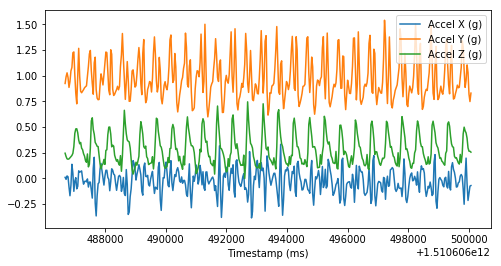

In [14]:
# task='WALKING'
sensor='accel'
loc = 'sacrum'
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim[-1,1]

TypeError: 'function' object is not subscriptable

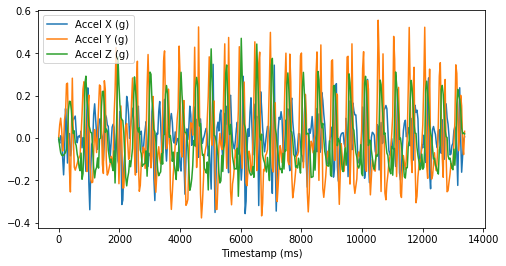

In [11]:
# HP filter

# task='WALKING'
sensor='accel'
loc = 'sacrum'
HPfilter(act_dict, task=task, loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim[-1,1]

### Compute power spectra with Welch method

In [30]:
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#

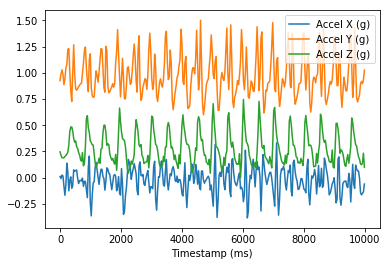

In [32]:
rawdata.plot()

In [33]:
Pxx = power_spectra_welch(rawdata,fm=0,fM=10)

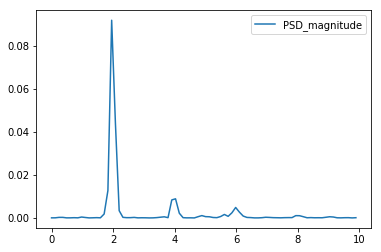

In [34]:
Pxx.plot()

In [35]:
np.nanmean(Pxx.values)

0.002445901749892828

In [37]:
# changed argmax to idxmax due to warning
domfreq = np.asarray([Pxx.iloc[:,-1].idxmax()])
Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total

In [38]:
x = rawdata.iloc[:,1]
Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
print(Fs)

31.23785936285936


In [39]:
sH_raw=[]
sH_raw.append(nolds.sampen(x)) #samp entr raw data

In [40]:
sH_raw

[1.2833463918674481]

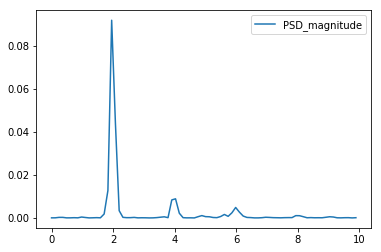

In [41]:
fm = 0; fM = 10
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
x = rawdata.iloc[:,-1]
n = len(x) #number of samples in clip
Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
f,Pxx_den = welch(x,Fs,nperseg=min(256,n))
#return PSD in desired interval of freq
inds = (f<=fM)&(f>=fm)
f=f[inds]
Pxx_den=Pxx_den[inds]
Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])
Pxxdf.plot()

In [42]:
Pxxdf.head()

,PSD_magnitude
0.000000,0.000033
0.122023,0.000048
0.244046,0.000251
0.366069,0.000249
0.488092,0.000029


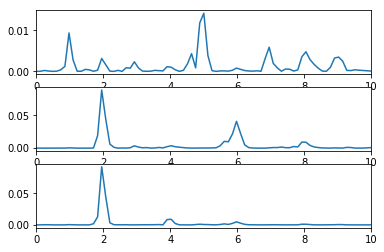

In [43]:
#signal features#signal  
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
fig = plt.figure()
# fp, ax_arr = plt.subplots(3, sharex=True)

for i in range(3):
    fig.add_subplot(3,1,i+1)
    x = rawdata.iloc[:,i]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=256)
    plt.plot(f,Pxx_den)
#     plt.semilogy(f,Pxx_den)
    plt.xlim([0,10])

# Aggregate features data with scores for given task - cycle through all subjects

DataPreprocessor2_wTime.ipynb

Data structure: 
- act_dict[task][trial][sensor]

for s in subjects:
1. aggregate raw data
- load subject file
- choose task and sensor location
- extract clips
2. feature extraction
- compute features on each trial
- Aggregate subj code (OMIT and score) with feature matrix

## 1. Generate clips and aggregate raw data
- performed only on HC02 below
- need to remove line to get all subjects


In [27]:
tasks = ['LYING','SITTING','STANDING','WALKING','STAIRS DOWN','STAIRS UP']

In [28]:
locs = ['bicep_left',
        'bicep_right',
        'posterior_forearm_left',
        'posterior_forearm_right',
        'medial_chest',
        'sacrum',
        'rectus_femoris_left',
        'rectus_femoris_right'
        'biceps_femoris_left',
        'biceps_femoris_right',
        'tibialis_anterior_left',
        'tibialis_anterior_right',
        'gastrocnemius_left',
        'gastrocnemius_right',
        'distal_lateral_shank_left',
        'distal_lateral_shank_right']
# if need to get locations again
# path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls\HC01'
# locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]

# If need to select a subgroup of sensors:
# locs = ['sacrum','distal_lateral_shank_left','distal_lateral_shank_right'] #sensor location

In [41]:
def DataAggregator_allLocs(tasks,clipsize=10000,overlap=0.9,locations=[],namesuffix=None,verbose=False):
# omitted arg: task_scores_all
    """
    Function: aggregate metadata and rawdata from all sensor (accel,gyro) locations
    Rawdata is clipped into sliding windows, so incorporates code from gen_clips()
    Metadata includes Subject, Trial, and Task
    
    startTS and endTS specificies fraction of raw sensors data to use to generate clips
    """

    t0=time.time()
#     #load subject scores (std motor assessments)
#     mot_scores = pd.read_excel(os.path.join(scores_path, 'Scores.xls'))

    #load subjects features data and assemble with scores/subj metadata
    d = os.listdir(dict_path)
    fnames = [filename[0:12] for filename in d if filename.startswith('HC')]
    
    ############################
    #test only on 1st subject (TO DEBUG) which should be HC02
    # skip HC01 - need to debug
    # Comment out section to run all subjects
    ############################
#    fnames=[fnames[0]]
    fnames = ['HC02dict.pkl']
    print('\nThe one subject we are testing on: ',fnames)

    clip_data = pd.DataFrame() #the table with features and metadata

    #loop through subjects
    print(fnames)
    for subj_filename in fnames:

        #load current subject sensor data
        subj = int(subj_filename[2:4]) #subj numerical code
        f = open(os.path.join(dict_path,subj_filename),'rb')    
        act_dict = pickle.load(f)
        f.close()
        print('\nLoaded Subj %s sensor data'%subj)

#         act_dict_left = gen_unimodal_data(act_dict_full, side='left')
#         act_dict_right = gen_unimodal_data(act_dict_full, side='right')

# Data structure: act_dict[task][trial][sensor]

        #loop through tasks for current subject
        for task in tasks: 

#             print('\nTask is ', task)

# discard side, so removed 1 indent
#            for side in ['left','right']:

            #select trials
            Trials = act_dict[task].keys()
            n_rec = len(Trials) #of sensor recordings

######################
# Note: gen_clips function starts around here...
######################
            #****EXTRACT RAW CLIPS FROM ALL LOCATIONS FOR CURRENT TRIAL AND APPEND***
            for trial in Trials:
#                 print('\nTrial is ', trial)

                clip_data_trial=pd.DataFrame() #storing all clips from current trial and side

                locs = act_dict[task][trial].keys()
#                 #choose to extract from all locations or only the ones contained in locations
#                 if len(locations) == 0: #all locations
#                     locs = act_dict[task][trial].keys()
#                     locs = [i for i in locs if (i.find(side)>0)] #choose sensors on current side
#                     locs.append('sacrum'); locs.append('medial_chest')
#                 else: #selected locations + Sacrum
#                     locs = locations
#                     locs = [i for i in locs if (i.find(side)>0)] #choose sensors on current side 
#                     locs.append('sacrum')


                # separating the side for locs..
                for location in locs:
#                     print('\nLocation is ', location)

                    for s in ['accel','gyro']:
#                         print('\nSensor is ', s)

                        if verbose:
                            print(task,' sensortype = %s - trial %d'%(s,trial))
                        #create clips and store in a list
                        rawdata = act_dict[task][trial][location][s].copy()
                        if rawdata.empty is True: #skip if no data for current sensor
                            continue
                        #reindex time (relative to start)
                        idx = rawdata.index
                        idx = idx-idx[0]
                        rawdata.index = idx
                        #create clips data
                        deltat = np.median(np.diff(rawdata.index))
                        clips = pd.DataFrame()

#################################
# Fine above
# WOrk on below
                        #take clips
#                             location_name = re.sub(side, '', location) #column name dataframe (remove side info)
                        # kept side for location name
                        location_name = location

                        idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
                        for i in idx:
                            c = (rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]).copy()
                            #add time information to clips
                            c['Time']=(c.index.values/1000)-(c.index.values/1000)[0]
#                             df = pd.DataFrame({location_name+'_'+s:[c.values]},index=[trial])
                            ##############
                            # Changed dataframe structure to parse our location, sensor, and raw data in unstacked form
                            df = pd.DataFrame({'location':location_name,'sensor':s,'rawdata':[c.values]})
                            clips=pd.concat((clips,df)) #concatenate clips from current trial

#                         ## keep this chunk and evaluate further if statements print
#                         nc = len(clips)
#                         if (nc < clip_data_trial.shape[0]) & (clip_data_trial.empty is False):
#                             print(trial,location+s,len(clips))
#                             nd = clip_data_trial.shape[0]-nc
#                             print('current sensor has less clips - adding %d empties'%nd)
#                             clips=pd.concat((clips,pd.DataFrame({location_name+'_'+s:np.empty(nd)},
#                                                                 index=[np.ones(nd)*trial])))
#                         if (nc > clip_data_trial.shape[0]) & (clip_data_trial.empty is False):
#                             print(trial,location+s,len(clips))
#                             nd = nc-clip_data_trial.shape[0]
#                             print('current sensor has more clips - discarding last %d clips'%nd)
#                             clips = clips.iloc[:-nd]
#                         # end of chunk #######

                        # may discard
#                         clips.reset_index(inplace=True, drop=True)  # temp fix unique indexing bug from gen_unimodal_data
#                                                                     # will look into, added 3/19/2018

                        clip_data_trial=pd.concat((clip_data_trial,clips),axis=1) #concatenate clips across locations

                #concatenates metadata to all clips for current trial
                clip_data_trial['Subject']=subj
                clip_data_trial['Task']=task
#                 clip_data_trial['Side']=side
                clip_data_trial['Trial']=trial #subj_score.iloc[visit]['visit']

                ####### error here ############
                clip_data = pd.concat((clip_data,clip_data_trial)) #concatenate clips across visits (index) 
# end of removed indent

    #SAVING DATA 
    metadata = ['Subject','Trial','Task']
    cols = clip_data.columns.tolist()
    cols = np.setdiff1d(cols,metadata).tolist()
    clip_data = clip_data[metadata+cols]
    print('\nClip Data matrix generated')
    print(clip_data.shape)

    if namesuffix == None:
        namesuffix=''
    saved_filename = 'DataRaw_AllLocs'+namesuffix+'.hdf5'
    clip_data.to_hdf(os.path.join(features_path,saved_filename),'w')
    print('Data matrix saved in ' + str(os.path.join(features_path,saved_filename)))
    t = time.time()
    eltime = (t-t0)/60
    print('Elapsed time = %.2f min'%eltime)

    return clip_data

# Test DataAggregator_allLocs()

In [42]:
# test out DataAggregator_allLocs
data = DataAggregator_allLocs(tasks,locations=locs,overlap=0.9,namesuffix='Test')


The one subject we are testing on:  ['HC02dict.pkl']
['HC02dict.pkl']

Loaded Subj 2 sensor data


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



ValueError: Plan shapes are not aligned

In [37]:
data.head(5)

,Subject,Trial,Task,bicep_left_accel,bicep_right_accel,biceps_femoris_left_accel,biceps_femoris_right_accel,distal_lateral_shank_left_accel,distal_lateral_shank_left_gyro,distal_lateral_shank_right_accel,...,posterior_forearm_left_accel,posterior_forearm_left_gyro,posterior_forearm_right_accel,posterior_forearm_right_gyro,rectus_femoris_left_accel,rectus_femoris_right_accel,sacrum_accel,sacrum_gyro,tibialis_anterior_left_accel,tibialis_anterior_right_accel
0,2,0,LYING,"[[-0.38129243915465016, 0.14459449149309567, 0...","[[-0.3920347905699244, -0.17718776226443864, 0...","[[0.1582665751125356, 0.12408636606393485, -0....","[[0.11334401464866062, 0.014709697108415297, -...","[[0.09527733272297212, -0.8621347371633479, -0...","[[1.1291676203554744, 0.7629510948347615, 1.00...","[[0.10528725108720494, 0.9057145037003131, -0....",...,"[[-0.08490119783321902, 0.9057145037003131, -0...","[[-1.3122758831159445, -1.4343480582895154, -0...","[[0.06646829938200938, -0.721141374837873, -0....","[[0.9460593575952316, 1.0070954451819034, -0.6...","[[-0.1850003814755472, -0.1854886701762415, 1....","[[-0.2367589837491417, 0.06060883497367797, 1....","[[-0.059754329747462975, 0.1826810101472498, -...","[[0.9460593575952316, 0.3356984817273769, 1.06...","[[-0.046814679179064456, -0.8983901731898984, ...","[[-0.19964904249637616, 0.9004654001678496, 0...."
1,2,0,LYING,"[[-0.3788509956511788, 0.13238727397573855, 0....","[[-0.39935912108033866, -0.17132829785610726, ...","[[0.1553368429083699, 0.12603952086671288, -0....","[[0.11334401464866062, 0.005920500495918191, -...","[[0.09430075532158357, -0.8609140154116122, -0...","[[1.1902037079423735, 0.8850232700083325, 1.06...","[[0.10565346761272564, 0.9057145037003131, -0....",...,"[[-0.08111696040283832, 0.904859998474098, -0....","[[0.09155413138023503, -1.3122758831159445, -0...","[[0.06561379415579438, -0.7190661478599223, -0...","[[0.09155413138023503, 0.8850232700083325, -0....","[[-0.19476615548943327, -0.1957427328908219, 1...","[[-0.24164187075608454, 0.053284504463263715, ...","[[-0.059998474097810124, 0.1814602883955141, -...","[[0.9460593575952316, 0.3356984817273769, 1.06...","[[-0.052185854886701584, -0.9052262149996184, ...","[[-0.1981841763942933, 0.9063248645761809, 0.4..."
2,2,0,LYING,"[[-0.3768978408484016, 0.13336385137712714, 0....","[[-0.38129243915465016, -0.1820706492713815, 0...","[[0.1616845960173956, 0.1201800564583806, -0.9...","[[0.12164492256046346, 0.007873655298695327, -...","[[0.09527733272297212, -0.8617685206378272, -0...","[[1.2512397955290453, 0.7629510948347615, 1.06...","[[0.10663004501411423, 0.9074235141527432, -0....",...,"[[-0.08075074387731762, 0.9019302662699324, -0...","[[-0.8850232700083325, -1.3733119707026162, -0...","[[0.06695658808270366, -0.7221179522392616, -0...","[[0.5188067444876197, 0.9460593575952316, -0.7...","[[-0.19427786678873904, -0.1850003814755472, 1...","[[-0.2435950255588617, 0.06353856717784367, 1....","[[-0.05902189669642155, 0.18158236057068766, -...","[[0.9460593575952316, 0.3356984817273769, 1.00...","[[-0.051697566186007286, -0.899366750591287, 0...","[[-0.1986724650949876, 0.9156023498893724, 0.4..."
3,2,0,LYING,"[[-0.38471046005951015, 0.13678187228198713, 0...","[[-0.3876401922636759, -0.18060578316929865, 0...","[[0.15777828641184133, 0.11969176775768632, -0...","[[0.11334401464866062, 0.009338521400778177, -...","[[0.09539940489814568, -0.860669871061265, -0....","[[1.1291676203554744, 0.8239871824216607, 1.00...","[[0.10467689021133708, 0.9055924315251396, -0....",...,"[[-0.08136110475318548, 0.9047379262989246, -0...","[[-1.0070954451819034, -1.3733119707026162, -0...","[[0.06463721675440581, -0.7215075913633937, -0...","[[0.5798428320745188, 0.8850232700083325, -0.7...","[[-0.2016021972991533, -0.18744182497901865, 1...","[[-0.244083314259556, 0.06060883497367797, 0.9...","[[-0.060975051499198685, 0.18207064927138195, ...","[[0.9460593575952316, 0.3356984817273769, 1.00...","[[-0.05365072098878443, -0.902784771496146

In [38]:
data.shape

(796, 24)

In [18]:
# Raw data from all sensors aggregated for subject HC02
# features_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\FeatureMatrix'
data2 = pd.read_hdf(os.path.join(features_path,'DataRaw_AllLocsHC02.hdf5'))

# Something's wrong. Too many rows for Lying?

In [20]:
data2.columns

Index(['Subject', 'Trial', 'Task', 'bicep_left_accel', 'bicep_right_accel',
       'biceps_femoris_left_accel', 'biceps_femoris_right_accel',
       'distal_lateral_shank_left_accel', 'distal_lateral_shank_left_gyro',
       'distal_lateral_shank_right_accel', 'distal_lateral_shank_right_gyro',
       'gastrocnemius_left_accel', 'gastrocnemius_right_accel',
       'medial_chest_accel', 'posterior_forearm_left_accel',
       'posterior_forearm_left_gyro', 'posterior_forearm_right_accel',
       'posterior_forearm_right_gyro', 'rectus_femoris_left_accel',
       'rectus_femoris_right_accel', 'sacrum_accel', 'sacrum_gyro',
       'tibialis_anterior_left_accel', 'tibialis_anterior_right_accel'],
      dtype='object')

In [23]:
data2.tail(20)

,Subject,Trial,Task,bicep_left_accel,bicep_right_accel,biceps_femoris_left_accel,biceps_femoris_right_accel,distal_lateral_shank_left_accel,distal_lateral_shank_left_gyro,distal_lateral_shank_right_accel,...,posterior_forearm_left_accel,posterior_forearm_left_gyro,posterior_forearm_right_accel,posterior_forearm_right_gyro,rectus_femoris_left_accel,rectus_femoris_right_accel,sacrum_accel,sacrum_gyro,tibialis_anterior_left_accel,tibialis_anterior_right_accel
3,2,3,WALKING,NaN,NaN,NaN,NaN,"[[-1.1021286335545892, 0.6624246585793854, -0....","[[91.0353246356908, 18.219272144655406, 226.65...","[[-1.2904859998474096, 0.2820477607385365, -0....",...,"[[-2.0629587243457688, 0.8958266575112539, 0.1...","[[-43.060959792477426, 22.49179827573039, -108...","[[-1.6245975432974746, 0.09063859006637642, -0...","[[145.78469520103772, 31.464103150987967, 19.1...",NaN,NaN,"[[-0.1102922102693218, 0.8883802548256661, 0.6...","[[67.90264744029946, 38.8494697489889, -71.076...",NaN,NaN
4,2,3,WALKING,NaN,NaN,NaN,NaN,"[[-0.2108796826123447, -0.5097123674372472, -0...","[[-3.7537193865873633, -15.289539940489705, -5...","[[-0.9333028152895396, 0.06036469062333082, -0...",...,"[[-0.8153810940718702, 0.20965896086060895, -0...","[[109.16304264896645, -21.57625696192872, -100...","[[-1.161089494163424, -0.4804150453955902, -0....","[[5.95101853971164, -25.72671091783013, -137.1...",NaN,NaN,"[[-0.4475776302738996, 0.8487067978942546, 0.2...","[[2.5329976348516543, -39.88708323796459, -28....",NaN,NaN
5,2,3,WALKING,NaN,NaN,NaN,NaN,"[[-1.020950637064164, 0.09515526054779856, -0....","[[-28.656443121995835, -12.787060349431613, 53...","[[-2.3621576256961934, -1.157671473258564, -0....",...,"[[-0.9373311970702676, 0.1284809643701843, -0....","[[-40.1922636758984, -35.67559319447628, 223.7...","[[-0.8108644235904476, -0.31219958800640857, -...","[[202.7924010070956, -2.105745021744042, 203.6...",NaN,NaN,"[[-0.07501335164415979, 0.7011215381094074, 0....","[[-16.083009079118032, -4.9134050507361735, -1...",NaN,NaN
6,2,3,WALKING,NaN,NaN,NaN,NaN,"[[-0.9828641184100101, 0.028625925078202382, -...","[[-51.66704814221407, 11.444266422522333, 104....","[[-0.2746013580529487, 0.4306095979247733, -0....",...,"[[-1.0758831158922717, 0.2904707408255129, -0....","[[95.97924773022078, 7.5379568169680615, 33.90...","[[-0.96235599298085, -0.0040894178683146265, -...","[[-81.69680323491252, -35.00419623102175, 100....",NaN,NaN,"[[-0.10528725108720538, 1.3622644388494694, 0....","[[12.420843823910902, -13.275349050125895, -32...",NaN,NaN
7,2,3,WALKING,NaN,NaN,NaN,NaN,"[[-1.102738994430457, -0.04608224612802303, -0...","[[-26.092927443350845, -13.763637750820179, 92...","[[-1.6769665064469366, -2.9477378500038145, 0....",...,"[[-0.6773174639505606, 0.13629358358129284, -0...","[[-9.430075532158297, -3.4485389486533222, 118...","[[-0.8117189288166626, -0.37628747997253376, -...","[[133.76058594644064, -5.828946364538068, 172....",NaN,NaN,"[[-0.07928587777523477, 0.9180437933928438, 0....","[[-18.280308232242305, 17.48683909361398, 3.81...",NaN,NaN
8,2,3,WALKING,NaN,NaN,NaN,NaN,"[[-0.4054627298390172, -0.20318913557640966, -...","[[8.270389868009488, 15.228503852903032, -255....","[[-1.0128938735027084, -0.0109254596780346, -0...",...,"[[-1.030106050202182, 0.20257877470054186, -0....","[[81.81887541008655, 21.51522087434182, -96.58...","[[-0.9973907072556648, -0.2520180056458381, -0...","[[-25.29945830472252, 36.835278858625095, -114...",NaN,NaN,"[[-0.12018005645838105, 0.6612039368276497, 0....","[[-14.496070801861606, -37.99496452277413, -22...",NaN,NaN
9,2,3,WALKING,NaN,NaN,NaN,NaN,"[[-1.0897993438620586, 0.07122911421377864, -0...","[[-39.337758449683406, -2.410925459678083, 47....","[[-1.7133440146486612, -2.8152895399404896, 0....",...,"[[-0.7992675669489584, 0.19647516594186326, -0...","[[-2.5940337224383256, -55.817502098115476, 20...","[[-0.6843976501106277, -0.2357824063477532, -0...","[[88.77698939497986, -19.50102998397801, 137.3...",NaN,NaN,"[[-0.04193179217212162, 

In [79]:
# Example of raw data aggregated for subject HC02
# would be same as loaded data2
data.head()

,Subject,Trial,Task,bicep_left_accel,bicep_right_accel,biceps_femoris_left_accel,biceps_femoris_right_accel,distal_lateral_shank_left_accel,distal_lateral_shank_left_gyro,distal_lateral_shank_right_accel,...,posterior_forearm_left_accel,posterior_forearm_left_gyro,posterior_forearm_right_accel,posterior_forearm_right_gyro,rectus_femoris_left_accel,rectus_femoris_right_accel,sacrum_accel,sacrum_gyro,tibialis_anterior_left_accel,tibialis_anterior_right_accel
0,2,0,LYING,"[[-0.38129243915465016, 0.14459449149309567, 0...","[[-0.3920347905699244, -0.17718776226443864, 0...","[[0.1582665751125356, 0.12408636606393485, -0....","[[0.11334401464866062, 0.014709697108415297, -...","[[0.09527733272297212, -0.8621347371633479, -0...","[[1.1291676203554744, 0.7629510948347615, 1.00...","[[0.10528725108720494, 0.9057145037003131, -0....",...,"[[-0.08490119783321902, 0.9057145037003131, -0...","[[-1.3122758831159445, -1.4343480582895154, -0...","[[0.06646829938200938, -0.721141374837873, -0....","[[0.9460593575952316, 1.0070954451819034, -0.6...","[[-0.1850003814755472, -0.1854886701762415, 1....","[[-0.2367589837491417, 0.06060883497367797, 1....","[[-0.059754329747462975, 0.1826810101472498, -...","[[0.9460593575952316, 0.3356984817273769, 1.06...","[[-0.046814679179064456, -0.8983901731898984, ...","[[-0.19964904249637616, 0.9004654001678496, 0...."
1,2,0,LYING,"[[-0.3764095521477073, 0.1079728389410235, 0.9...","[[-0.4042420080872815, -0.16302738994430446, 0...","[[0.16363775082017273, 0.11578545815213205, -0...","[[0.12359807736324058, 0.003967345693141056, -...","[[0.09564354924849283, -0.8621347371633479, -0...","[[1.1291676203554744, 0.7629510948347615, 1.00...","[[0.10614175631341992, 0.907179369802396, -0.3...",...,"[[-0.0838025482566569, 0.9033951323720152, -0....","[[-1.1902037079423735, -1.3122758831159445, -0...","[[0.06378271152819083, -0.718577859159228, -0....","[[0.8239871824216607, 1.0070954451819034, -0.7...","[[-0.19769588769359905, -0.1820706492713815, 1...","[[-0.237247272449836, 0.057679102769512276, 1....","[[-0.05902189669642155, 0.18341344319829125, -...","[[0.9460593575952316, 0.2746623941404778, 1.06...","[[-0.05120927748531301, -0.9022964827954528, 0...","[[-0.2055085069047076, 0.9121843289845124, 0.4..."
2,2,0,LYING,"[[-0.382757305256733, 0.13922331578545855, 0.9...","[[-0.38959334706645293, -0.17084000915541298, ...","[[0.16314946211947845, 0.122621499961852, -0.9...","[[0.10308995193408066, 0.015686274509803866, -...","[[0.09539940489814568, -0.8595712214847029, -0...","[[1.2512397955290453, 0.8239871824216607, 1.06...","[[0.10614175631341992, 0.9069352254520489, -0....",...,"[[-0.08233768215457404, 0.904859998474098, -0....","[[-0.6408789196611906, -1.3733119707026162, -0...","[[0.06561379415579438, -0.7213855191882201, -0...","[[0.6408789196611906, 0.8850232700083325, -0.6...","[[-0.1967193102922105, -0.18646524757763008, 1...","[[-0.24164187075608454, 0.057679102769512276, ...","[[-0.05914396887159513, 0.1835355153734648, -0...","[[0.9460593575952316, 0.3356984817273769, 1.06...","[[-0.049744411383230165, -0.904737926298924, 0...","[[-0.1986724650949876, 0.9092545967803468, 0.4..."
3,2,0,LYING,"[[-0.3822690165560387, 0.11725032425421487, 0....","[[-0.3876401922636759, -0.16644541084916442, 0...","[[0.16314946211947845, 0.12115663385976914, -0...","[[0.11236743724727204, 0.01617456321049815, -0...","[[0.09613183794918713, -0.8607919432364386, -0...","[[1.1902037079423735, 0.8239871824216607, 1.00...","[[0.1058976119630728, 0.9070572976272224, -0.3...",...,"[[-0.07891966124971406, 0.9032730601968416, -0...","[[-0.7629510948347615, -1.3733119707026162, -0...","[[0.06695658808270366, -0.7196765087357901, -0...","[[0.3967345693140487, 1.0681315327688026, -0.8...","[[-0.20404364080262472, -0.18304722667277007, ...","[[-0.23627069504844744, 0.04986648355840373, 1...","[[-0.058777752346074415, 0.18292515449759691, ...","[[0.9460593575952316, 0.3356984817273769, 1.00...","[[-0.047791256580453016, -0.89887846189059

In [ ]:
# reset index
datadata  = data.reset_index(drop=True)
data.head()

In [80]:
data.tail()

,Subject,Trial,Task,bicep_left_accel,bicep_right_accel,biceps_femoris_left_accel,biceps_femoris_right_accel,distal_lateral_shank_left_accel,distal_lateral_shank_left_gyro,distal_lateral_shank_right_accel,...,posterior_forearm_left_accel,posterior_forearm_left_gyro,posterior_forearm_right_accel,posterior_forearm_right_gyro,rectus_femoris_left_accel,rectus_femoris_right_accel,sacrum_accel,sacrum_gyro,tibialis_anterior_left_accel,tibialis_anterior_right_accel
1,2,0,STAIRS UP,"[[-0.8578622110322729, 0.2276035706111239, -0....","[[-1.2006408789196614, -0.5087357900358587, -0...","[[-0.9003433279926756, 0.13922331578545855, -0...","[[-0.2167391470206761, 0.8047608148317691, -0....","[[-1.942351415274281, -0.4491645685511561, -0....","[[-183.93224994277875, 60.39520866712428, 70.0...","[[-1.2904859998474096, -0.05279621576256943, -...",...,"[[-1.0015411612115663, 0.14544899671931066, -0...","[[-83.77203021286323, -65.40016784924093, -40....","[[-1.0952925917448693, -0.21857022964827968, -...","[[-78.70603494316015, 4.547188525215461, -33.8...","[[-1.5487907225146866, -0.014099336232547444, ...","[[-2.3866941329060807, -1.2045471885252157, -0...","[[-0.1610742351415273, 0.8272220950637061, 0.7...","[[11.932555123216614, 85.23689631494653, 56.24...","[[-1.9477225909819185, 0.02935835812924381, -0...","[[-1.3983978027008468, 0.4341496910048068, -0...."
2,2,0,STAIRS UP,"[[-0.8275883115892273, 0.17877470054169553, -0...","[[-0.7523918516823072, -0.3378347447928589, -0...","[[-0.7650873579003585, 0.19977111467154973, -0...","[[-1.08540474555581, 0.21100175478751826, -0.3...","[[-0.9792019531548029, 0.14056610971236785, -0...","[[-11.20012207217519, 4.547188525215461, -5.21...","[[0.1369039444571607, 0.5850308995193405, 0.16...",...,"[[-1.015823605706874, -0.09112687876707116, 0....","[[-13.763637750820179, -55.63439383535524, 128...","[[-0.9019302662699319, 0.27765316243228805, -0...","[[41.10780498970007, 4.730296787975932, -11.38...","[[-0.96235599298085, -0.2494544899671931, 0.12...","[[-0.9853055619134814, 0.15094224460212136, -0...","[[0.020447089341573133, 0.8954604409857332, 0....","[[10.589761196307336, 7.354848554207593, 20.59...","[[-1.0077668421454185, 0.10992599374380063, -0...","[[-0.024841687647821686, -0.06732280460822483,..."
0,2,1,STAIRS UP,NaN,NaN,NaN,NaN,"[[-1.2449530785076677, -0.0820935378042269, -0...","[[72.35828183413469, 52.76569771877621, 177.52...","[[-0.9807888914320592, 0.02532997634851597, -0...",...,"[[-1.0523231860837718, 0.2377355611505303, -0....","[[-155.06218051422888, 2.8992141603723667, 44....","[[-1.0475623712520026, -0.3019455252918286, -0...","[[-20.965896086060862, -17.120622568093268, 18...",NaN,NaN,"[[-0.13531700617990386, 0.98628213931487, 0.24...","[[-6.622415503166168, 1.0681315327688026, -22....",NaN,NaN
1,2,1,STAIRS UP,NaN,NaN,NaN,NaN,"[[-0.36786449988555736, -1.2874341954680704, 0...","[[-272.12939650568387, 119.17296101319927, 59....","[[-1.0146028839551384, 0.033997100785839514, 0...",...,"[[-1.327229724574655, 0.3294117647058821, 0.46...","[[-70.09994659342328, 117.7080949111164, -66.0...","[[-1.2207827878233006, -0.3441824979018846, -0...","[[-78.9501792935073, -22.369726100556818, -154...",NaN,NaN,"[[-0.2990157930876629, 0.6854962996871903, 0.2...","[[-14.618142977035177, 91.0353246356908, -12.7...",NaN,NaN
2,2,1,STAIRS UP,NaN,NaN,NaN,NaN,"[[-1.4510109102006563, -0.1957427328908219, 0....","[[-43.060959792477426, -52.27740901808193, 97....","[[-0.9429465171282524, 0.11224536507209848, -0...",...,"[[-1.227985046158541, 0.35138475623712484, -0....","[[52.58258945601574, 15.10643167772946, -149.0...","[[-1.2022278171969178, -0.01971465629053171, -...","[[38.8494697489889, 7.2327763790340205, -28.90...",NaN,NaN,"[[-0.3468680857557032, 0.941359578850996, 0.42...","[[11.139085984588293, -56.610971236743815, -5....",NaN,NaN


In [81]:
data.columns

Index(['Subject', 'Trial', 'Task', 'bicep_left_accel', 'bicep_right_accel',
       'biceps_femoris_left_accel', 'biceps_femoris_right_accel',
       'distal_lateral_shank_left_accel', 'distal_lateral_shank_left_gyro',
       'distal_lateral_shank_right_accel', 'distal_lateral_shank_right_gyro',
       'gastrocnemius_left_accel', 'gastrocnemius_right_accel',
       'medial_chest_accel', 'posterior_forearm_left_accel',
       'posterior_forearm_left_gyro', 'posterior_forearm_right_accel',
       'posterior_forearm_right_gyro', 'rectus_femoris_left_accel',
       'rectus_femoris_right_accel', 'sacrum_accel', 'sacrum_gyro',
       'tibialis_anterior_left_accel', 'tibialis_anterior_right_accel'],
      dtype='object')

In [82]:
data.sacrum_accel.iloc[0].shape

(313, 4)

In [84]:
data.sacrum_gyro.iloc[0].shape

(313, 4)

In [85]:
data.tibialis_anterior_left_accel.iloc[0].shape

(313, 4)

In [86]:
data.tibialis_anterior_right_accel.iloc[0].shape

(315, 4)

In [90]:
data.posterior_forearm_right_accel.iloc[0].shape

(313, 4)

# Work from here...

# Data from all locations

## 2. feature extraction
- compute features on each trial
- Aggregate subj code (OMIT and score) with feature matrix



### load data and reconvert from dict to dataframe with metadata
f = open(os.path.join(features_path,'DataRaw_AllLocsHandsThighBack.pkl'),'rb')
data = pickle.load(f)
f.close()

f = open(os.path.join(features_path,'Features_AllLocsHandsThighBack.pkl'),'rb')
features = pickle.load(f)
f.close()

metadata = ['Subject','Visit','Side','Task','Tremor','Bradykinesia','Dyskinesia']
features_new = pd.concat([data[metadata],features],axis=1)

print('saving hdf file...')
features_new.to_hdf(os.path.join(features_path,'Features_AllLocsUnfiltered.hdf5'),'w')
print('hdf file saved in %s'%(features_path))

## Need to find how/where they made Feature_AllLocs...
checked:
https://github.com/kamshee/CIS_PD/blob/master/DataPreprocessor_AllLocs2.ipynb
https://github.com/kamshee/CIS_PD/blob/master/DataPreprocessor2_wTime.ipynb
https://github.com/kamshee/CIS_PD/blob/master/Training-Set-Selection.ipynb
https://github.com/kamshee/CIS_PD/blob/master/Models-Features-AndrewVer3.ipynb

### Task list
- transform column names of sensor locations to a single column - use Melt option
- discard empty values at this step?
- extract features from raw data
- BUT, need to combine acc and gyro into one row, maybe separate step
    - relabel colnames with 'acc' or 'gyr' appended
    - only ankle, wrist, and sacrum have gyr data - I'd have a problem with NANs for the rest of the sensors...
- current 3 options
    1. dataset only with ankle, wrist, and sacrum sensors - both acc and gyr features
    2. dataset with all sensors but only acc features
    3. change NaN to 0


In [10]:
# Raw data from all sensors aggregated for subject HC02
# features_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\FeatureMatrax'
data2 = pd.read_hdf(os.path.join(features_path,'DataRaw_AllLocsHC02.hdf5'))

In [11]:
data2.head()

,Subject,Trial,Task,bicep_left_accel,bicep_right_accel,biceps_femoris_left_accel,biceps_femoris_right_accel,distal_lateral_shank_left_accel,distal_lateral_shank_left_gyro,distal_lateral_shank_right_accel,...,posterior_forearm_left_accel,posterior_forearm_left_gyro,posterior_forearm_right_accel,posterior_forearm_right_gyro,rectus_femoris_left_accel,rectus_femoris_right_accel,sacrum_accel,sacrum_gyro,tibialis_anterior_left_accel,tibialis_anterior_right_accel
0,2,0,LYING,"[[-0.38129243915465016, 0.14459449149309567, 0...","[[-0.3920347905699244, -0.17718776226443864, 0...","[[0.1582665751125356, 0.12408636606393485, -0....","[[0.11334401464866062, 0.014709697108415297, -...","[[0.09527733272297212, -0.8621347371633479, -0...","[[1.1291676203554744, 0.7629510948347615, 1.00...","[[0.10528725108720494, 0.9057145037003131, -0....",...,"[[-0.08490119783321902, 0.9057145037003131, -0...","[[-1.3122758831159445, -1.4343480582895154, -0...","[[0.06646829938200938, -0.721141374837873, -0....","[[0.9460593575952316, 1.0070954451819034, -0.6...","[[-0.1850003814755472, -0.1854886701762415, 1....","[[-0.2367589837491417, 0.06060883497367797, 1....","[[-0.059754329747462975, 0.1826810101472498, -...","[[0.9460593575952316, 0.3356984817273769, 1.06...","[[-0.046814679179064456, -0.8983901731898984, ...","[[-0.19964904249637616, 0.9004654001678496, 0...."
1,2,0,LYING,"[[-0.3764095521477073, 0.1079728389410235, 0.9...","[[-0.4042420080872815, -0.16302738994430446, 0...","[[0.16363775082017273, 0.11578545815213205, -0...","[[0.12359807736324058, 0.003967345693141056, -...","[[0.09564354924849283, -0.8621347371633479, -0...","[[1.1291676203554744, 0.7629510948347615, 1.00...","[[0.10614175631341992, 0.907179369802396, -0.3...",...,"[[-0.0838025482566569, 0.9033951323720152, -0....","[[-1.1902037079423735, -1.3122758831159445, -0...","[[0.06378271152819083, -0.718577859159228, -0....","[[0.8239871824216607, 1.0070954451819034, -0.7...","[[-0.19769588769359905, -0.1820706492713815, 1...","[[-0.237247272449836, 0.057679102769512276, 1....","[[-0.05902189669642155, 0.18341344319829125, -...","[[0.9460593575952316, 0.2746623941404778, 1.06...","[[-0.05120927748531301, -0.9022964827954528, 0...","[[-0.2055085069047076, 0.9121843289845124, 0.4..."
2,2,0,LYING,"[[-0.382757305256733, 0.13922331578545855, 0.9...","[[-0.38959334706645293, -0.17084000915541298, ...","[[0.16314946211947845, 0.122621499961852, -0.9...","[[0.10308995193408066, 0.015686274509803866, -...","[[0.09539940489814568, -0.8595712214847029, -0...","[[1.2512397955290453, 0.8239871824216607, 1.06...","[[0.10614175631341992, 0.9069352254520489, -0....",...,"[[-0.08233768215457404, 0.904859998474098, -0....","[[-0.6408789196611906, -1.3733119707026162, -0...","[[0.06561379415579438, -0.7213855191882201, -0...","[[0.6408789196611906, 0.8850232700083325, -0.6...","[[-0.1967193102922105, -0.18646524757763008, 1...","[[-0.24164187075608454, 0.057679102769512276, ...","[[-0.05914396887159513, 0.1835355153734648, -0...","[[0.9460593575952316, 0.3356984817273769, 1.06...","[[-0.049744411383230165, -0.904737926298924, 0...","[[-0.1986724650949876, 0.9092545967803468, 0.4..."
3,2,0,LYING,"[[-0.3822690165560387, 0.11725032425421487, 0....","[[-0.3876401922636759, -0.16644541084916442, 0...","[[0.16314946211947845, 0.12115663385976914, -0...","[[0.11236743724727204, 0.01617456321049815, -0...","[[0.09613183794918713, -0.8607919432364386, -0...","[[1.1902037079423735, 0.8239871824216607, 1.00...","[[0.1058976119630728, 0.9070572976272224, -0.3...",...,"[[-0.07891966124971406, 0.9032730601968416, -0...","[[-0.7629510948347615, -1.3733119707026162, -0...","[[0.06695658808270366, -0.7196765087357901, -0...","[[0.3967345693140487, 1.0681315327688026, -0.8...","[[-0.20404364080262472, -0.18304722667277007, ...","[[-0.23627069504844744, 0.04986648355840373, 1...","[[-0.058777752346074415, 0.18292515449759691, ...","[[0.9460593575952316, 0.3356984817273769, 1.00...","[[-0.047791256580453016, -0.89887846189059

# There shouldn't be so many Trial 0...

In [12]:
data2.columns.values

array(['Subject', 'Trial', 'Task', 'bicep_left_accel',
       'bicep_right_accel', 'biceps_femoris_left_accel',
       'biceps_femoris_right_accel', 'distal_lateral_shank_left_accel',
       'distal_lateral_shank_left_gyro',
       'distal_lateral_shank_right_accel',
       'distal_lateral_shank_right_gyro', 'gastrocnemius_left_accel',
       'gastrocnemius_right_accel', 'medial_chest_accel',
       'posterior_forearm_left_accel', 'posterior_forearm_left_gyro',
       'posterior_forearm_right_accel', 'posterior_forearm_right_gyro',
       'rectus_femoris_left_accel', 'rectus_femoris_right_accel',
       'sacrum_accel', 'sacrum_gyro', 'tibialis_anterior_left_accel',
       'tibialis_anterior_right_accel'], dtype=object)

In [15]:
# melt option to unpivot sensor locations
columns = ['bicep_left_accel',
       'bicep_right_accel', 'biceps_femoris_left_accel',
       'biceps_femoris_right_accel', 'distal_lateral_shank_left_accel',
       'distal_lateral_shank_left_gyro',
       'distal_lateral_shank_right_accel',
       'distal_lateral_shank_right_gyro', 'gastrocnemius_left_accel',
       'gastrocnemius_right_accel', 'medial_chest_accel',
       'posterior_forearm_left_accel', 'posterior_forearm_left_gyro',
       'posterior_forearm_right_accel', 'posterior_forearm_right_gyro',
       'rectus_femoris_left_accel', 'rectus_femoris_right_accel',
       'sacrum_accel', 'sacrum_gyro', 'tibialis_anterior_left_accel',
       'tibialis_anterior_right_accel']
pd.melt(data2, id_vars=['Subject', 'Trial', 'Task'], value_vars=columns, var_name='locations', value_name='rawdata')

,Subject,Trial,Task,locations,rawdata
0,2,0,LYING,bicep_left_accel,"[[-0.38129243915465016, 0.14459449149309567, 0..."
1,2,0,LYING,bicep_left_accel,"[[-0.3764095521477073, 0.1079728389410235, 0.9..."
2,2,0,LYING,bicep_left_accel,"[[-0.382757305256733, 0.13922331578545855, 0.9..."
3,2,0,LYING,bicep_left_accel,"[[-0.3822690165560387, 0.11725032425421487, 0...."
4,2,0,LYING,bicep_left_accel,"[[-0.3822690165560387, 0.13922331578545855, 0...."
5,2,0,LYING,bicep_left_accel,"[[-0.3632257572289617, 0.1231097886625463, 0.9..."
6,2,0,LYING,bicep_left_accel,"[[-0.3739681086442359, 0.12603952086671288, 0...."
7,2,0,LYING,bicep_left_accel,"[[-0.3837338826581216, 0.13043411917296144, 0...."
8,2,0,LYING,bicep_left_accel,"[[-0.3749446860456245, 0.12652780956740714, 0...."
9,2,0,LYING,bicep_left_accel,"[[-0.3837338826581216, 0.12994583047226715, 0...."


# Check data

In [ ]:

datadata==DataAggregator_allLocsDataAgg (tasks,task_scores,overlap=0,namesuffix='FullDataset_Overlap')

In [ ]:
data =pd.read_hdf(os.path.join(features_path, 'DataRawFullDataset.hdf5'))

In [ ]:
datadata  =pd.read_hdf(os.path.join(features_path, '../FeatureMatrix/DataRaw_AllLocsFullDataset.hdf5'))

In [ ]:
datadata..headhead((33))

In [ ]:
print(len(data))
print(len(data.Subject.unique()))

# Extract features

In [ ]:
#rawdata is a numpy array
def feature_extraction_array(rawdata):

    if np.size(rawdata) == 1:
#         print('empty')
        return np.empty([])
    
    time = rawdata[:,-1]
    Fs = np.mean(1/(np.diff(time))) #mean sampling rate in clip

    #remove time column 
    if rawdata.shape[1] > 3:
        rawdata = rawdata[:,:-1] 
        
    #Root mean square of signal on each axis
    N = np.shape(rawdata)[0]
    RMS = 1/N*np.sqrt(np.asarray(np.sum(rawdata**2,axis=0)))

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis
    mean = np.asarray(np.mean(rawdata,axis=0))
    var = np.asarray(np.std(rawdata,axis=0))
    sk = skew(rawdata)
    kurt = kurtosis(rawdata)

    #Cross-correlation between axes pairs
    xcorr_xy = np.correlate(rawdata[:,0],rawdata[:,1],mode='same')
    # xcorr_xy = xcorr_xy/np.abs(np.sum(xcorr_xy)) #normalize values
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_lag_xy = (np.argmax(xcorr_xy))/np.shape(xcorr_xy)[0] #normalized lag

    xcorr_xz = np.correlate(rawdata[:,0],rawdata[:,2],mode='same')
    # xcorr_xz = xcorr_xz/np.abs(np.sum(xcorr_xz)) #normalize values
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_lag_xz = (np.argmax(xcorr_xz))/np.shape(xcorr_xz)[0]

    xcorr_yz = np.correlate(rawdata[:,1],rawdata[:,2],mode='same')
    # xcorr_yz = xcorr_yz/np.abs(np.sum(xcorr_yz)) #normalize values
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_lag_yz = (np.argmax(xcorr_yz))/np.shape(xcorr_yz)[0]

    #pack xcorr features
    xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
    xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])

    #Dominant freq and relative magnitude (on acc magnitude)
    xnorm = np.linalg.norm(rawdata,axis=1)
    n = np.shape(xnorm)[0] #number of samples in clip
    f,Pxx = welch(xnorm,Fs,nperseg=min(256,n))
    Pxx=Pxx[(f > 0) & (f <= 10)] #frequency range between 0 and 10 Hz
    domfreq = f[Pxx.argmax()].reshape(-1)
    Pdom_rel = (max(Pxx)/np.sum(Pxx)).reshape(-1) #power at dominant freq rel to total

    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx),np.nanstd(Pxx),skew(Pxx),kurtosis(Pxx)])

    #moments of jerk magnitude
    jerk = np.diff(xnorm)
    jerk_moments = np.array([np.nanmean(jerk),np.nanstd(jerk),skew(jerk[~np.isnan(jerk)]),kurtosis(jerk[~np.isnan(jerk)])])

    #sample entropy raw data (magnitude) and FFT
    sH_raw = []; sH_fft = []

    for a in range(3):
        x = rawdata[:,a]
        n = np.shape(x)[0] #number of samples in clip
        sH_raw.append(nolds.sampen(x)) #samp entr raw data
        #for now disable SH on fft
        # f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
        # sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft
    sH_raw=np.asarray(sH_raw)
    
    #Assemble features in array
    X = np.concatenate((RMS,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel,Pxx_moments,jerk_moments,sH_raw))
    return X

In [ ]:
# Modify...

# extract all data
t1 = time.time()
F = data.iloc[:,7:].applymap(feature_extraction_array)
dataF = data.iloc[:,:7]
dataF=pd.concat((dataF,F),axis=1)
print((time.time()-t1)/60)

In [ ]:
# Modify...

printprint(('saving hdf file...''saving  )
dataF.to_hdf(os.path.join(features_path,'Features_HP+LP.h5'),'w')
print('hdf file saved in %s'%(features_path))